---
## Python Packages & Directories
---

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import (division, print_function, absolute_import,
                        unicode_literals)
import  sys, os, glob, time, IPython

import astropy.constants as const
import astropy.units as u
from astropy.io import fits
from astropy.io import ascii
# from astropy.table import Table
# from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord, EarthLocation

# from PyAstronomy import pyasl

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

plt.rcParams["font.family"] = "Times New Roman"

import numpy as np
import scipy as sp
import pandas as pd
import math

import seaborn as sns
sns.set_palette("colorblind")
colors = palette1 = [
    # "#000000", # 1 Black
    "#FF6F00", # 2 Orange
    "#0072B2", # 3 Blue
    "#009E73", # 4 Pine Green
    "#D61310", # 5 Red
    "#DFB600", # 5 Yellow
    "#7A553F", # 7 Brown
    "#56B4E9", # 8 Skyblue
    "#C53CDA", # 9 Purple
    "#FFBBAD", # 10 Light Peach
    "#FF5C3F", # 11 Vibrant Orange
    "#00FF00", # 12 Green
    "#00FFFF", # 13 Cyan
    "#FF6AE1", # 14 Magenta
    "#DCD35A", # 15 Muted Yellow
    "#7F2039", # 16 Crimson
    "#31438E", # 17 Dark Blue
    "#AFAFAF", # 18 Gray
    "#2C5340", # 19 Dark Green
    "#A4420D", # 20 Dark Orange
]

#sns.color_palette("colorblind", 10) + sns.color_palette("Paired", 10)[2:] + sns.color_palette("Set2", 10)

# from smh import Session

import spag.read_data as rd
import spag.convert as convert
# import alexmods.read_data as rd


script_dir = "/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]) + "/"
# script_dir = os.path.dirname(os.path.realpath(__file__))+"/"
data_dir = script_dir+"../../spag/spag/data/"
plotting_dir = script_dir+"plots/plots-20250526-MW-only/"
table_dir = "/Users/ayelland/Research/metal-poor-stars/project/carbon-project-2025/tables/tables-20250521/"
table2_dir_clean = table_dir+"cfe-tables-2-plots-clean/"
if not os.path.exists(plotting_dir):
    os.makedirs(plotting_dir)


        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


In [2]:
## Show all columns and rows of the dataframe
pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

---
## Plotting Functions for `[C/Fe]` Ratios
---

In [3]:
def plot_feh_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, xlim=(-6.1, -0.9), ylim=(-1.7, 4.2), bins_width=0.10):
    """
    Plot [C/Fe] vs [Fe/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [C/Fe]"

    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    # figsize_x = scale * (xlim[1] - xlim[0])
    # figsize_y = scale * (ylim[1] - ylim[0])
    figsize_x = scale * 9.0
    figsize_y = scale * 5.0

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    # ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("bottom", size=1.5, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("left", size=1.5, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()


    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'], placco2014_clean_df['[C/Fe]'], 
        s=15, zorder=3,
        color='blue', alpha=1, marker='o',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[C/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'], placco2014_dirty_df['[C/Fe]'], 
        s=15, zorder=3,
        color='red', alpha=1, marker='s',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[C/Fe]'])))+")"
    )

    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Fe/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='blue', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Fe/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='red', alpha=1.0)
    ax_histx.hist(placco2014_df['[Fe/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='black', alpha=1.0)
    ax_histy.hist(placco2014_clean_df['[C/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='blue', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[C/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='red', alpha=1.0)
    ax_histy.hist(placco2014_df['[C/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='black', alpha=1.0)
    
    ## A(C) = 7.1 line ---> [C/Fe] = (7.1 - rd.get_solar('C')[0]) - feh, for CEMP-no / CEMP-s criteria
    def CEMP_no_cfe(feh):
        return (7.1 - rd.get_solar('C')[0]) - feh
    feh_intersect = 7.1 - rd.get_solar('C')[0] - (0.7)
    feh_vals = np.linspace(xlim[0], feh_intersect, 100)
    ax_scatter.plot(feh_vals, CEMP_no_cfe(feh_vals), color='k', linestyle='--', label="_A(C) = 7.1", zorder=2)

    ## [C/Fe] = 0.7 line, for CEMP criteria
    ax_scatter.axhline(y=0.7, color='orange', linestyle='--', label="_[C/Fe] = + 0.7", zorder=2)

    ## Titles and Labels
    ax_scatter.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel([])
    ax_scatter.set_ylabel([])
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)
    ax_scatter.text(-5.5, 0.75, r"$\uparrow$CEMP$\uparrow$", fontsize=14, color='orange', rotation_mode='anchor', ha='left', va='bottom')
    ax_scatter.text(-5.5, 0.65, r"[C/Fe] = + 0.7", fontsize=14, color='orange', rotation_mode='anchor', ha='left', va='top')
    # ax_scatter.text(-2.5, 2.8, r"CEMP-s", fontsize=14, color='purple', ha='left', va='bottom')
    # ax_scatter.text(-4.5, 2.1, r"CEMP-no", fontsize=14, color='green', ha='left', va='top')

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(0.5))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ## Histogram parameters
    ax_histx.tick_params(axis='both', which='both', direction='in', bottom=True, top=False, left=False, labelbottom=True, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', direction='in', bottom=False, top=False, left=True, labelbottom=False, labelleft=True)
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)
    ax_histx.set_xlabel("[Fe/H]", fontsize=14, color='k')
    ax_histy.set_ylabel("[C/Fe]", fontsize=14, color='k')

    ## Add legends
    ax_scatter.legend(loc='upper right', bbox_to_anchor=(xlim[1], ylim[1]), fontsize=13, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_feh_cfe.png", dpi=300)

    return fig

In [4]:
def plot_feh_bah(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-6.0, -1.9), ylim=(-6, 1), bins_width=0.10):
    """
    Plot [Ba/H] vs [Fe/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Ba/H]"


    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'].to_numpy(), placco2014_clean_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'].to_numpy(), placco2014_clean_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'].to_numpy(), placco2014_dirty_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'].to_numpy(), placco2014_dirty_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/Fe]'])))+")"
    )

    ## Add data to histograms
    ax_histy.hist(placco2014_clean_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Titles and Labels
    ax_scatter.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Fe/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Ba/H]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.set_xticklabels([])
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_feh_bah.png", dpi=300)

    return fig

In [5]:
def plot_feh_srh(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, xlim=(-6.0, -1.9), ylim=(-6, -1), bins_width=0.10):
    """
    Plot [Sr/H] vs [Fe/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"

    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'].to_numpy(), placco2014_clean_df['[Sr/H]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1, marker='o',
        # edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Sr/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'], placco2014_clean_df['ul[Sr/Fe]'], 
        s=15, zorder=3,
        color='blue', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Sr/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'].to_numpy(), placco2014_dirty_df['[Sr/H]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1, marker='s',
        # edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Sr/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'], placco2014_dirty_df['ul[Sr/Fe]'],
        s=15, zorder=3,
        color='red', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Sr/Fe]'])))+")"
    )

    ## Add data to histograms
    ax_histy.hist(placco2014_clean_df['[Sr/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Sr/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[Sr/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Titles and Labels
    ax_scatter.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Fe/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Sr/H]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.set_xticklabels([])
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_feh_srh.png", dpi=300)
    
    return fig

In [6]:
def plot_feh_srba(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-6.0, -1.9), ylim=(-3, 2), bins_width=0.10):
    """
    Plot [Sr/Ba] vs [Fe/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"


    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'].to_numpy(), placco2014_clean_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=4, marker='o',
        color='b', alpha=1,
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Sr/Ba]'].to_numpy())))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Fe/H]'].to_numpy(), placco2014_clean_df['ul[Sr/Ba]'].to_numpy(),
        s=15, zorder=4, marker='v',
        color='blue', alpha=1,
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Sr/Ba]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'].to_numpy(), placco2014_dirty_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=4, marker='s',
        color='r', alpha=1,
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Sr/Ba]'].to_numpy())))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Fe/H]'].to_numpy(), placco2014_dirty_df['ul[Sr/Ba]'].to_numpy(),
        s=15, zorder=4, marker='v',
        color='red', alpha=1,
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Sr/Ba]'])))+")"
    )

    ## Add data to histograms
    ax_histy.hist(placco2014_clean_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Titles and Labels
    ax_scatter.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Fe/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Sr/Ba]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.set_xticklabels([])
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_feh_srba.png", dpi=300)

    return fig

In [7]:
def plot_srh_bah(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-6, 0), ylim=(-6, 1), bins_width=0.10):
    """
    Plot [Ba/H] vs [Sr/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"


    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", size=0.8, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Sr/H]'].to_numpy(), placco2014_clean_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Sr/H]'].to_numpy(), placco2014_clean_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['ul[Sr/H]'].to_numpy(), placco2014_clean_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Sr/H]'].to_numpy(), placco2014_dirty_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Sr/H]'].to_numpy(), placco2014_dirty_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['ul[Sr/H]'].to_numpy(), placco2014_dirty_df['[Ba/H]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/H]'])))+")"
    )

    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='b', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='r', alpha=1.0)
    ax_histx.hist(placco2014_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='k', alpha=1.0)
    ax_histy.hist(placco2014_clean_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[Ba/H]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Titles and Labels
    ax_histx.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Sr/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Ba/H]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histx.set_yticklabels([])
    ax_histy.set_xticklabels([])
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_srh_bah.png", dpi=300)

    return fig

In [8]:
def plot_srfe_bafe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-2.2, 3.2), ylim=(-2.2, 3.2), bins_width=0.10):
    """
    Plot [Ba/Fe] vs [Sr/Fe] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/Fe]"


    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", size=0.8, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Sr/Fe]'].to_numpy(), placco2014_clean_df['[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Sr/Fe]'].to_numpy(), placco2014_clean_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['ul[Sr/Fe]'].to_numpy(), placco2014_clean_df['[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Sr/Fe]'].to_numpy(), placco2014_dirty_df['[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Sr/Fe]'].to_numpy(), placco2014_dirty_df['ul[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/Fe]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['ul[Sr/Fe]'].to_numpy(), placco2014_dirty_df['[Ba/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/Fe]'])))+")"
    )

    ## Add line for [Sr/Fe] = [Ba/Fe]
    ax_scatter.plot(xlim, xlim, color='k', linestyle='--', alpha=0.5, zorder=2)

    ## Add line for [Ba/Fe] = 0.6
    ax_scatter.axhline(y=1.0, color='orange', linestyle='--', label="_[Ba/Fe] = 0.6", zorder=2)
    ax_scatter.axhline(y=0.6, color='pink', linestyle='--', label="_[Ba/Fe] = 0.6", zorder=2)

    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Sr/Fe]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='b', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Sr/Fe]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='r', alpha=1.0)
    ax_histx.hist(placco2014_df['[Sr/Fe]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='k', alpha=1.0)
    ax_histy.hist(placco2014_clean_df['[Ba/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Ba/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[Ba/Fe]'], bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Titles and Labels
    ax_histx.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Sr/Fe]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Ba/Fe]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histx.set_yticklabels([])
    ax_histy.set_xticklabels([])
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_srfe_bafe.png", dpi=300)

    return fig

In [9]:
def plot_bafe_srba(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-3, 3), ylim=(-3, 2), bins_width=0.10):
    """
    Plot [Sr/Ba] vs [Ba/Fe] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"


    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", size=0.8, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Ba/Fe]'].to_numpy(), placco2014_clean_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Sr/Ba]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['[Ba/Fe]'].to_numpy(), placco2014_clean_df['ul[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Sr/Ba]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['ul[Ba/Fe]'].to_numpy(), placco2014_clean_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Ba/Fe]'].to_numpy(), placco2014_dirty_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Sr/Ba]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Ba/Fe]'].to_numpy(), placco2014_dirty_df['ul[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='v',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Sr/Ba]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['ul[Ba/Fe]'].to_numpy(), placco2014_dirty_df['[Sr/Ba]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/H]'])))+")"
    )

    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Ba/Fe]'].to_numpy(), bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='b', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Ba/Fe]'].to_numpy(), bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='r', alpha=1.0)
    ax_histx.hist(placco2014_df['[Ba/Fe]'].to_numpy(), bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='k', alpha=1.0)
    ax_histy.hist(placco2014_clean_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[Sr/Ba]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## r-process range
    rect = patches.Rectangle((xlim[0], -0.4), (xlim[1] - xlim[0]), (0.4 - 0.5), linewidth=1, edgecolor='k', facecolor='k', alpha=0.1, zorder=0)
    ax_scatter.add_patch(rect)

    ## s-process range
    ax_scatter.axhline(y=-1, color='orange', linestyle='--', label="_[Sr/Ba] = -1.0", zorder=2)
    ax_scatter.axvline(x=1, color='orange', linestyle='--', label="_[Ba/Fe] = -1.0", zorder=2)

    ## Add line for [Ba/Fe] = 0.6
    ax_scatter.axvline(x=0.6, color='pink', linestyle='--', label="_[Ba/Fe] = 0.6", zorder=2)

    ## Make a line with the two points
    point1 = (-2, 1)
    point2 = (1.8, -2)
    line = np.array([point1, point2])
    ax_scatter.plot(line[:, 0], line[:, 1], color='orange', linestyle='--', label="_[Sr/Ba] = -1.0", zorder=2)

    ## Titles and Labels
    ax_histx.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Ba/Fe]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[Sr/Ba]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histx.set_yticklabels([])
    ax_histy.set_xticklabels([])
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_bafe_srba.png", dpi=300)

    return fig

In [10]:
def plot_bah_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-6, 1), ylim=(-2, 4), bins_width=0.10):
    """
    Plot [C/Fe] vs [Ba/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"

    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", size=0.8, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Ba/H]'].to_numpy(), placco2014_clean_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['ul[Ba/H]'].to_numpy(), placco2014_clean_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Ba/H]'].to_numpy(), placco2014_dirty_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Ba/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['ul[Ba/H]'].to_numpy(), placco2014_dirty_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Ba/H]'])))+")"
    )

    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Ba/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='b', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Ba/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='r', alpha=1.0)
    ax_histx.hist(placco2014_df['[Ba/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='k', alpha=1.0)

    ax_histy.hist(placco2014_clean_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Low Ba Line
    ax_scatter.axvline(x=-4.0, color='green', linestyle='--', label="_[Ba/H] = -4.0", zorder=2)

    ## Carbon Line
    ax_scatter.axhline(y=0.7, color='orange', linestyle='--', label="_[C/Fe] = 0.7", zorder=2)

    ## Titles and Labels
    ax_histx.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Ba/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[C/Fe]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histx.set_yticklabels([])
    ax_histy.set_xticklabels([])
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)
    
    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_bah_cfe.png", dpi=300)

    return fig

In [11]:
def plot_srh_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title=None, ulim=True, xlim=(-6, 0), ylim=(-2, 4), bins_width=0.10):
    """
    Plot [C/Fe] vs [Sr/H] scatter plot with histograms on the y-axis.
    """

    title = title if title is not None else "[Fe/H] vs [Sr/H]"

    ## Calculate the histogram bin width and number of bins
    def adjust_bin_width(xlim, ylim, initial_width, step=0.01, max_width=1.0):
        bins_width = initial_width
        while bins_width <= max_width:  # Prevents infinite loop
            nbins_x = (xlim[1] - xlim[0]) / bins_width
            nbins_y = (ylim[1] - ylim[0]) / bins_width
            
            # Check if the bin numbers are close to whole numbers
            if np.isclose(nbins_x, round(nbins_x)) and np.isclose(nbins_y, round(nbins_y)):
                return bins_width, int(round(nbins_x))+1, int(round(nbins_y))+1
            bins_width += step  # Increment slightly

        # Fallback: Return the closest possible bin width
        bins_width = initial_width
        nbins_x = int(round((xlim[1] - xlim[0]) / initial_width)) + 1
        nbins_y = int(round((ylim[1] - ylim[0]) / initial_width)) + 1

        return bins_width, nbins_x, nbins_y

    bins_width, nbins_x, nbins_y = adjust_bin_width(xlim, ylim, bins_width)
    nbins = (nbins_x, nbins_y)

    bins_x = np.arange(xlim[0], xlim[1] + bins_width, bins_width) + 1e-8
    bins_y = np.arange(ylim[0], ylim[1] + bins_width, bins_width) + 1e-8

    ## Create a new figure
    scale = 2.0
    figsize_x = scale * (xlim[1] - xlim[0])
    figsize_y = scale * (ylim[1] - ylim[0])

    fig, ax_scatter = plt.subplots(figsize=(figsize_x, figsize_y))
    ax_scatter.set_aspect('equal')  # Ensure aspect ratio is equal
    
    divider = make_axes_locatable(ax_scatter)
    ax_histx = divider.append_axes("top", size=0.8, pad=0, sharex=ax_scatter)
    ax_histy = divider.append_axes("right", size=0.8, pad=0, sharey=ax_scatter)
    ax_histy.invert_yaxis()

    ## Milky Way Data
    ax_scatter.scatter(
        placco2014_clean_df['[Sr/H]'].to_numpy(), placco2014_clean_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='b', alpha=1.0, marker='o',
        edgecolors='none',
        label="placco2014_clean_df ("+str(np.sum(pd.notna(placco2014_clean_df['[Sr/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_clean_df['ul[Sr/H]'].to_numpy(), placco2014_clean_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='blue', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_clean_df_ul ("+str(np.sum(pd.notna(placco2014_clean_df['ul[Sr/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['[Sr/H]'].to_numpy(), placco2014_dirty_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='r', alpha=1.0, marker='s',
        edgecolors='none',
        label="placco2014_dirty_df ("+str(np.sum(pd.notna(placco2014_dirty_df['[Sr/H]'])))+")"
    )
    ax_scatter.scatter(
        placco2014_dirty_df['ul[Sr/H]'].to_numpy(), placco2014_dirty_df['[C/Fe]'].to_numpy(),
        s=15, zorder=3,
        color='red', alpha=1, marker='<',
        # edgecolors='black', linewidths=0.5,
        label="placco2014_dirty_df_ul ("+str(np.sum(pd.notna(placco2014_dirty_df['ul[Sr/H]'])))+")"
    )
    
    ## Add data to histograms
    ax_histx.hist(placco2014_clean_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='b', alpha=1.0)
    ax_histx.hist(placco2014_dirty_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='r', alpha=1.0)
    ax_histx.hist(placco2014_df['[Sr/H]'], bins=bins_x, histtype=u'step', orientation='vertical', range=(xlim[0], xlim[1]), color='k', alpha=1.0)
    ax_histy.hist(placco2014_clean_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='b', alpha=1.0)
    ax_histy.hist(placco2014_dirty_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='r', alpha=1.0)
    ax_histy.hist(placco2014_df['[C/Fe]'].to_numpy(), bins=bins_y, histtype=u'step', orientation='horizontal', range=(ylim[0], ylim[1]), color='k', alpha=1.0)

    ## Low Sr Line
    ax_scatter.axvline(x=-4.5, color='green', linestyle='--', label="_[Sr/H] = -4.5", zorder=2)

    ## Carbon Line
    ax_scatter.axhline(y=0.7, color='orange', linestyle='--', label="_[C/Fe] = 0.7", zorder=2)

    ## Titles and Labels
    ax_histx.set_title(title, fontsize=20, color='k')
    ax_scatter.set_xlabel("[Sr/H]", fontsize=14, color='k')
    ax_scatter.set_ylabel("[C/Fe]", fontsize=14, color='k')
    ax_scatter.set_xlim(xlim)
    ax_scatter.set_ylim(ylim)

    ## Ticks and Grids
    ax_scatter.xaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.yaxis.set_major_locator(MultipleLocator(1))
    ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax_scatter.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelbottom=True, labelleft=True)
    ax_scatter.tick_params(which='major', length=6)
    ax_scatter.tick_params(which='minor', length=2)
    ax_scatter.grid(True, which='major', linestyle='--', alpha=0.3, zorder=1)

    ax_histx.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histy.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
    ax_histx.set_yticklabels([])
    ax_histy.set_xticklabels([])
    ax_histx.grid(True, which='major', axis='x', linestyle='--', alpha=0.3, zorder=1)
    ax_histy.grid(True, which='major', axis='y', linestyle='--', alpha=0.3, zorder=1)

    ## Add legends
    ax_scatter.legend(loc='upper left', bbox_to_anchor=(xlim[0], ylim[1]), fontsize=9, frameon=True, borderaxespad=0.3, bbox_transform=ax_scatter.transData) 

    ## Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(plotting_dir+title+"_srh_cfe.png", dpi=300)

    return fig

---
## Making the plots and doing the comparison
---

In [12]:
## Base/Unmodifed Placco2014 MW data
placco2014_df = rd.load_placco2014()
placco2014_df = placco2014_df[[
    'Reference', 'Ref', 'Name', 'MP_key', 'Ncap_key', 'C_key', 
    'Teff', 'logg', '[Fe/H]',
    'epsc', 'epsc_c', 'epsc_f', 
    '[C/H]', '[C/H]f', '[C/Fe]', '[C/Fe]f', 
    '[N/Fe]', 'ul[N/Fe]',
    '[Ba/H]', 'ul[Ba/H]', '[Ba/Fe]', 'ul[Ba/Fe]',
    '[Sr/H]', 'ul[Sr/H]', '[Sr/Fe]', 'ul[Sr/Fe]', 
    '[Sr/Ba]','ul[Sr/Ba]', 'I/O'
]]
placco2014_df.sort_values(by=['Name'], inplace=True)
print("Placco2014: ", len(placco2014_df))

Placco2014:  615


### Placco+2014 Sample

In [13]:
## Cleaned Placco2014 MW data
placco2014_clean_df = placco2014_df[placco2014_df['I/O'] == '1'].copy()
placco2014_clean_df.sort_values(by=['Name'], inplace=True)
print("Clean: ", len(placco2014_clean_df))

## Dirty Placco2014 MW data (stars not in the clean table)
placco2014_dirty_df = placco2014_df[~placco2014_df['Name'].isin(placco2014_clean_df['Name'])]
print("Dirty: ", len(placco2014_dirty_df))

print()
# display(list(placco2014_df.columns))

Clean:  504
Dirty:  111



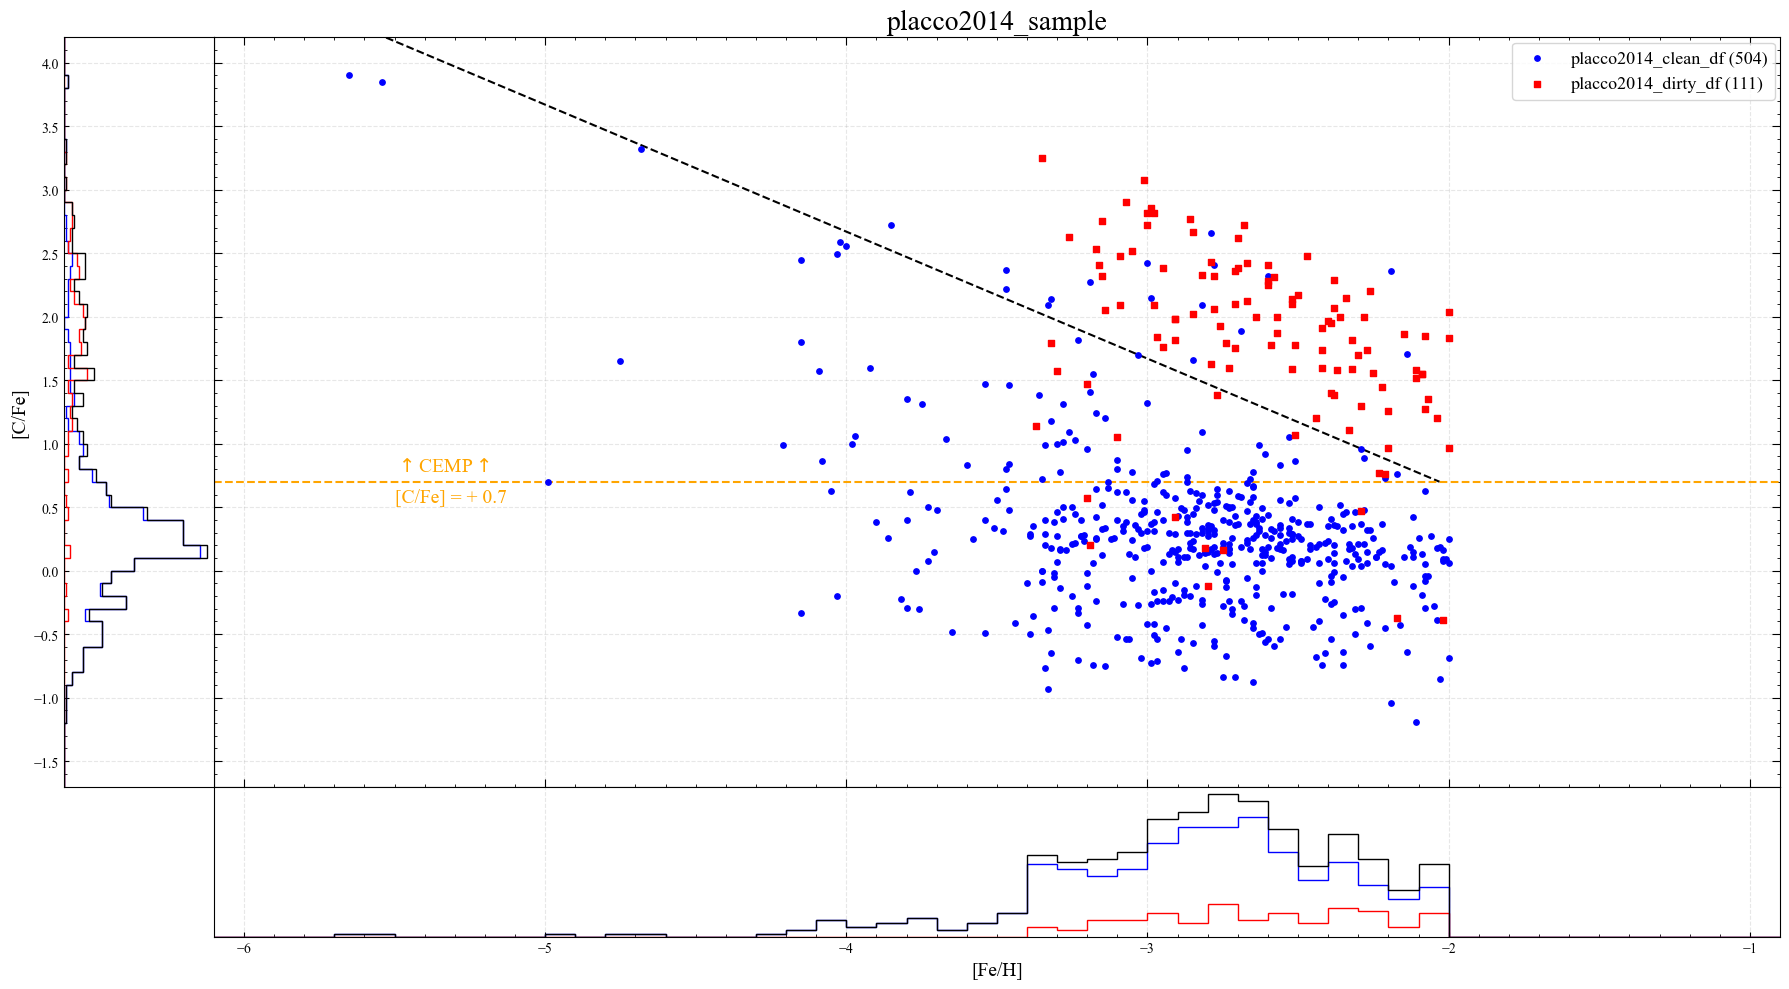

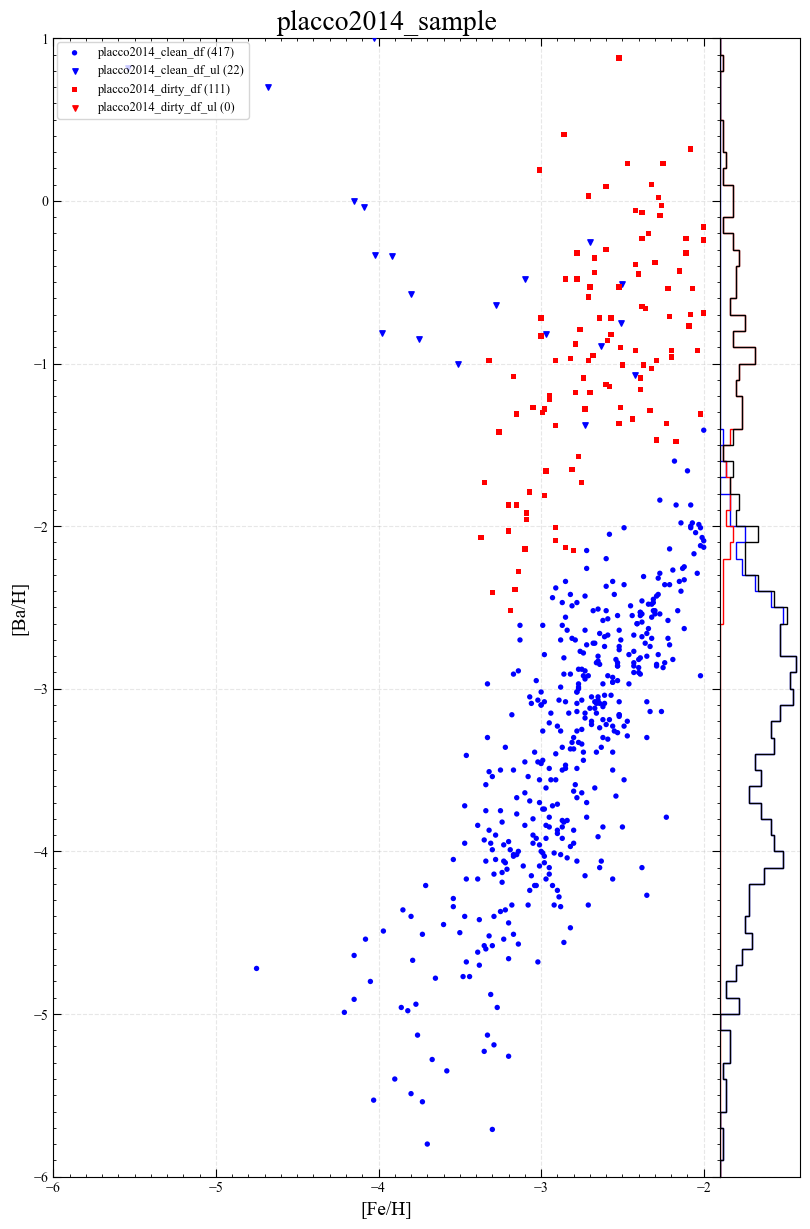

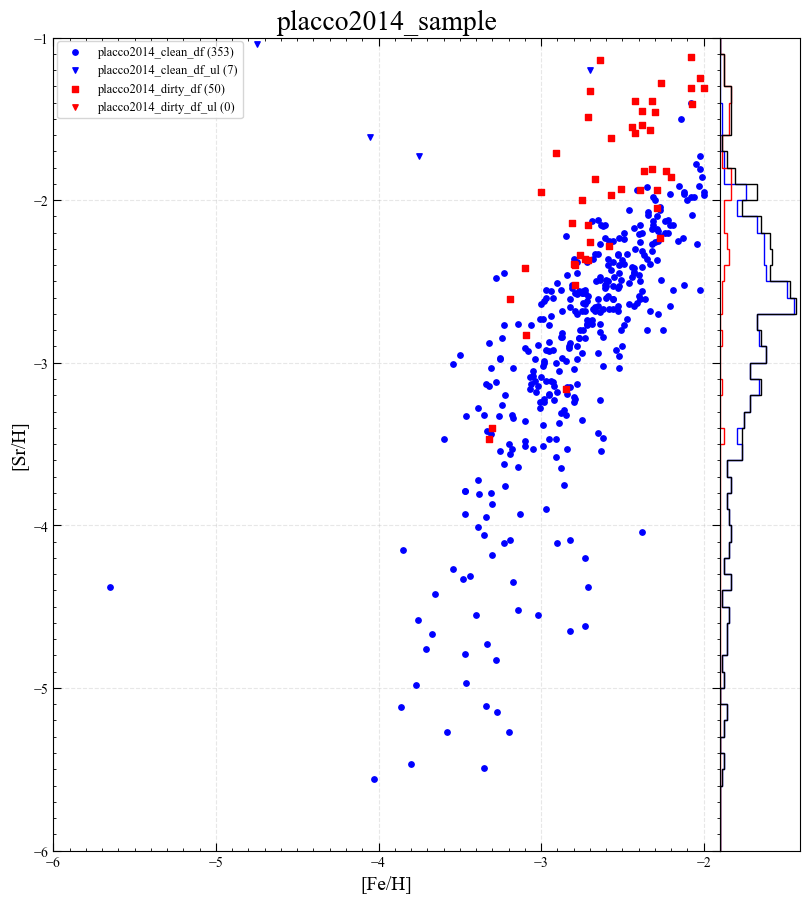

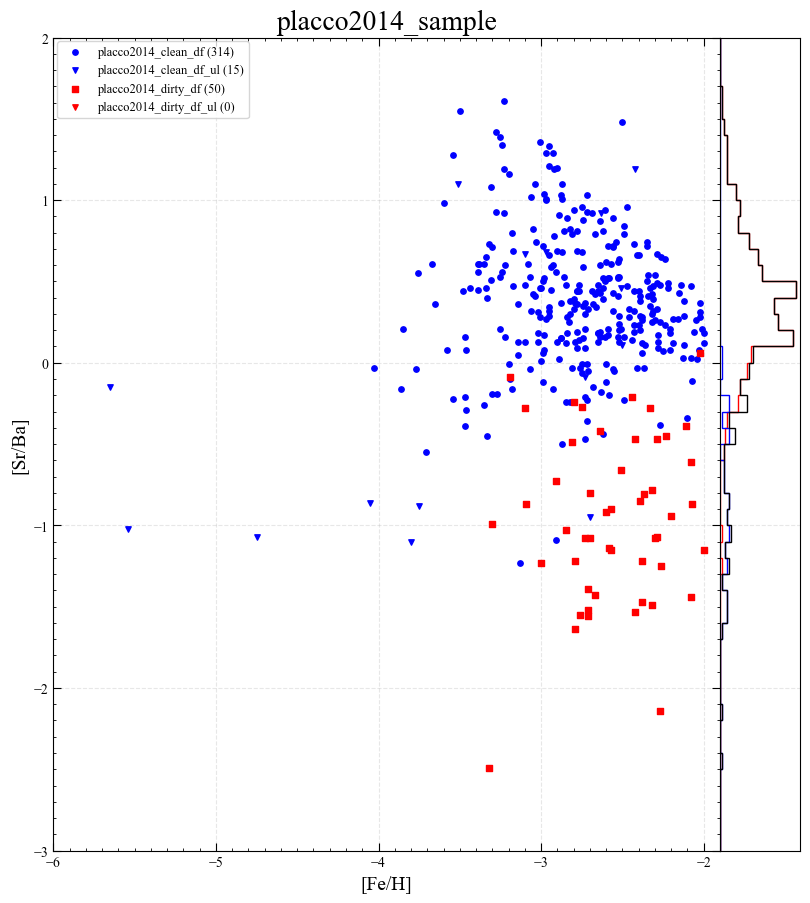

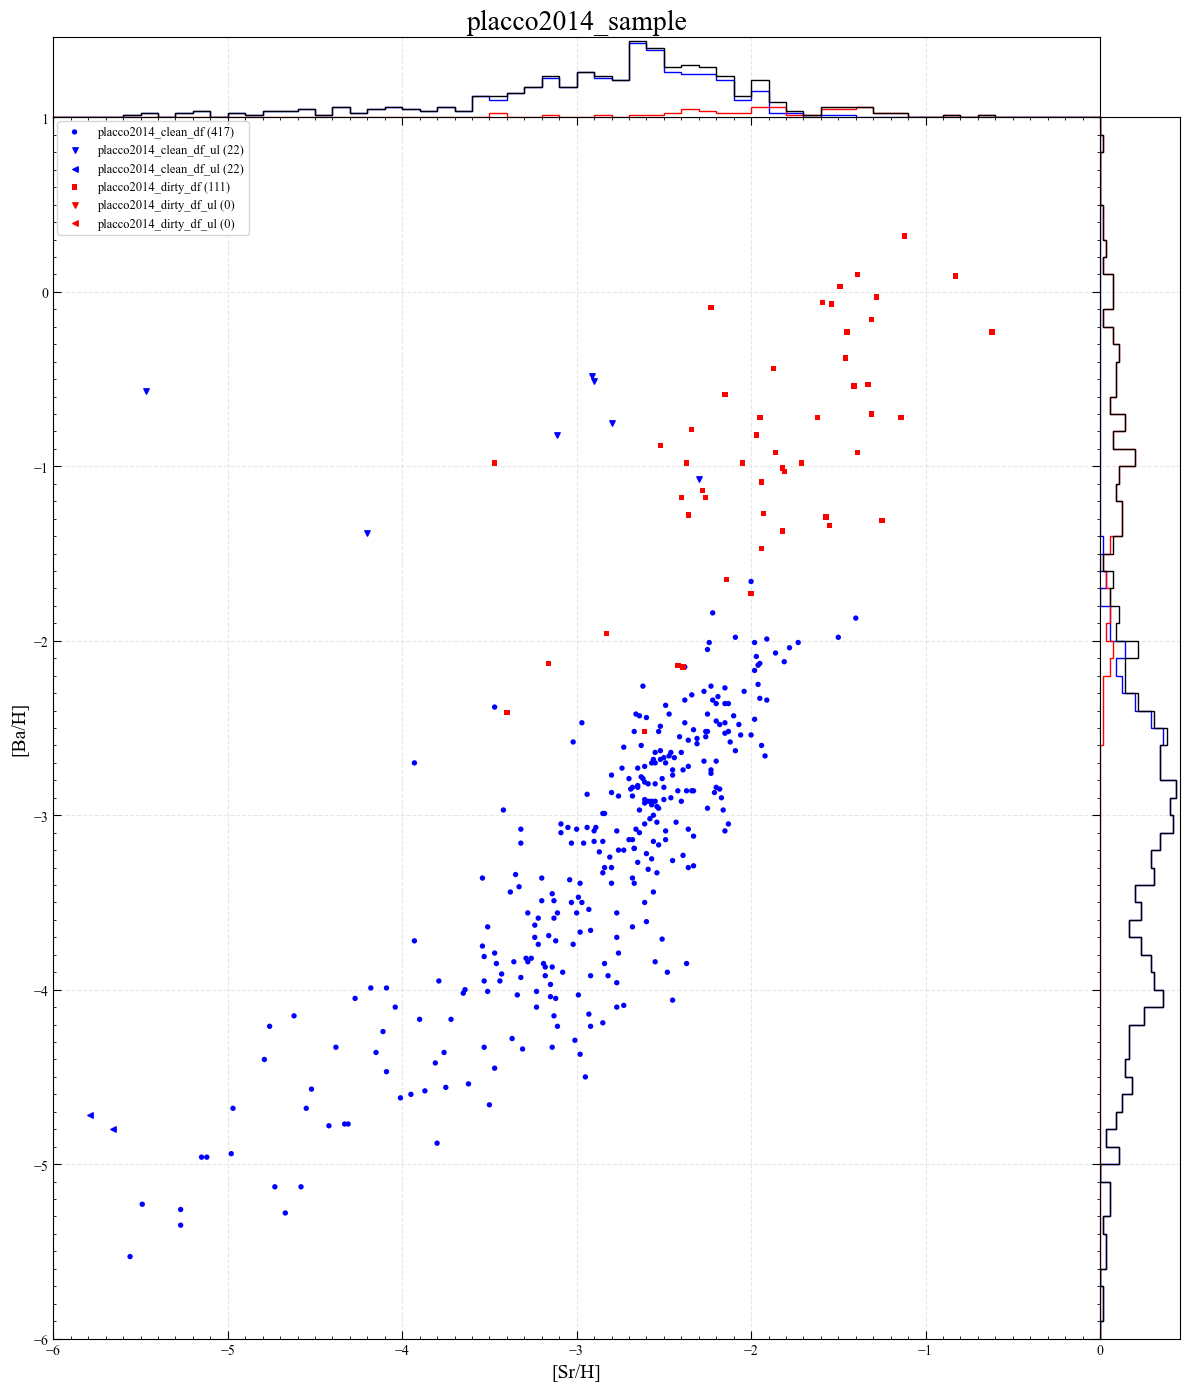

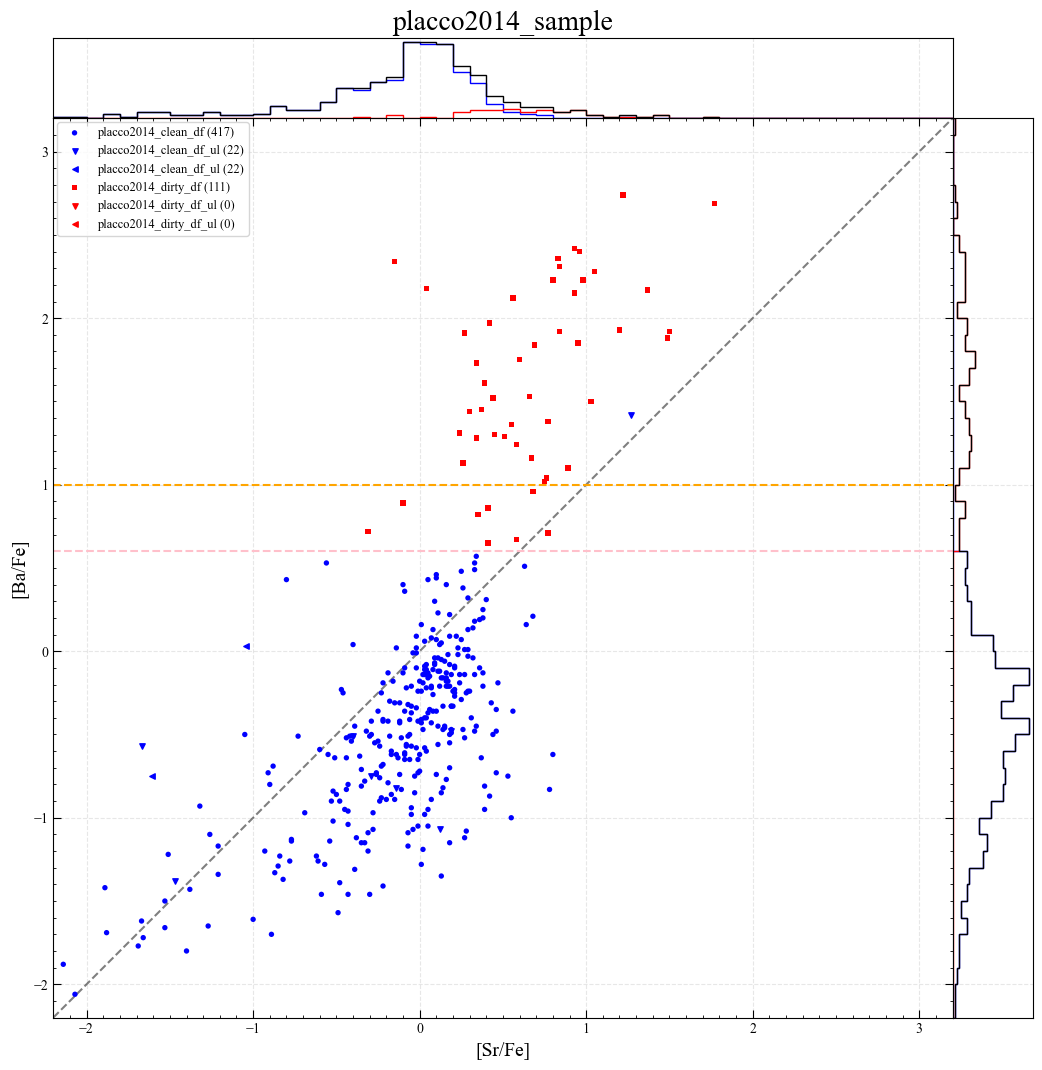

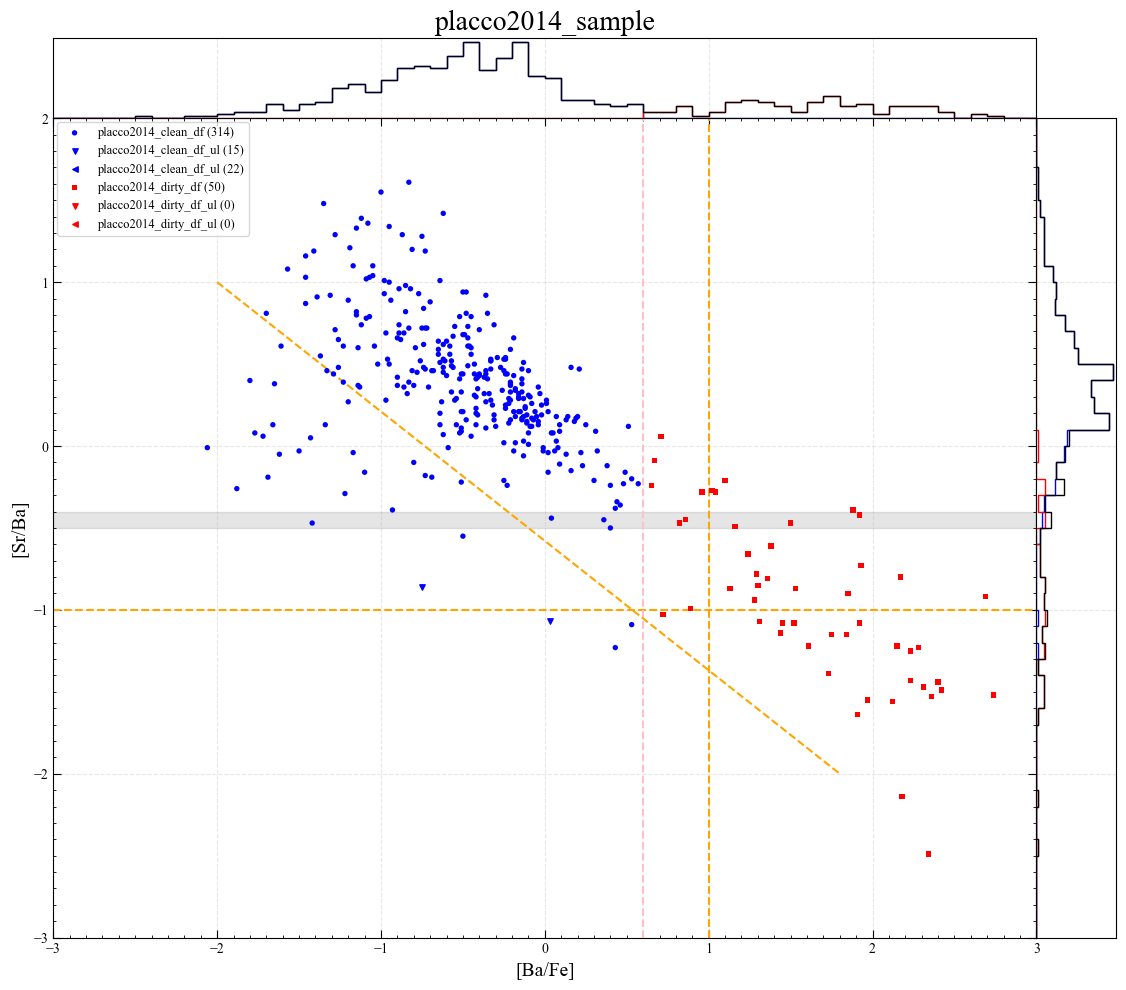

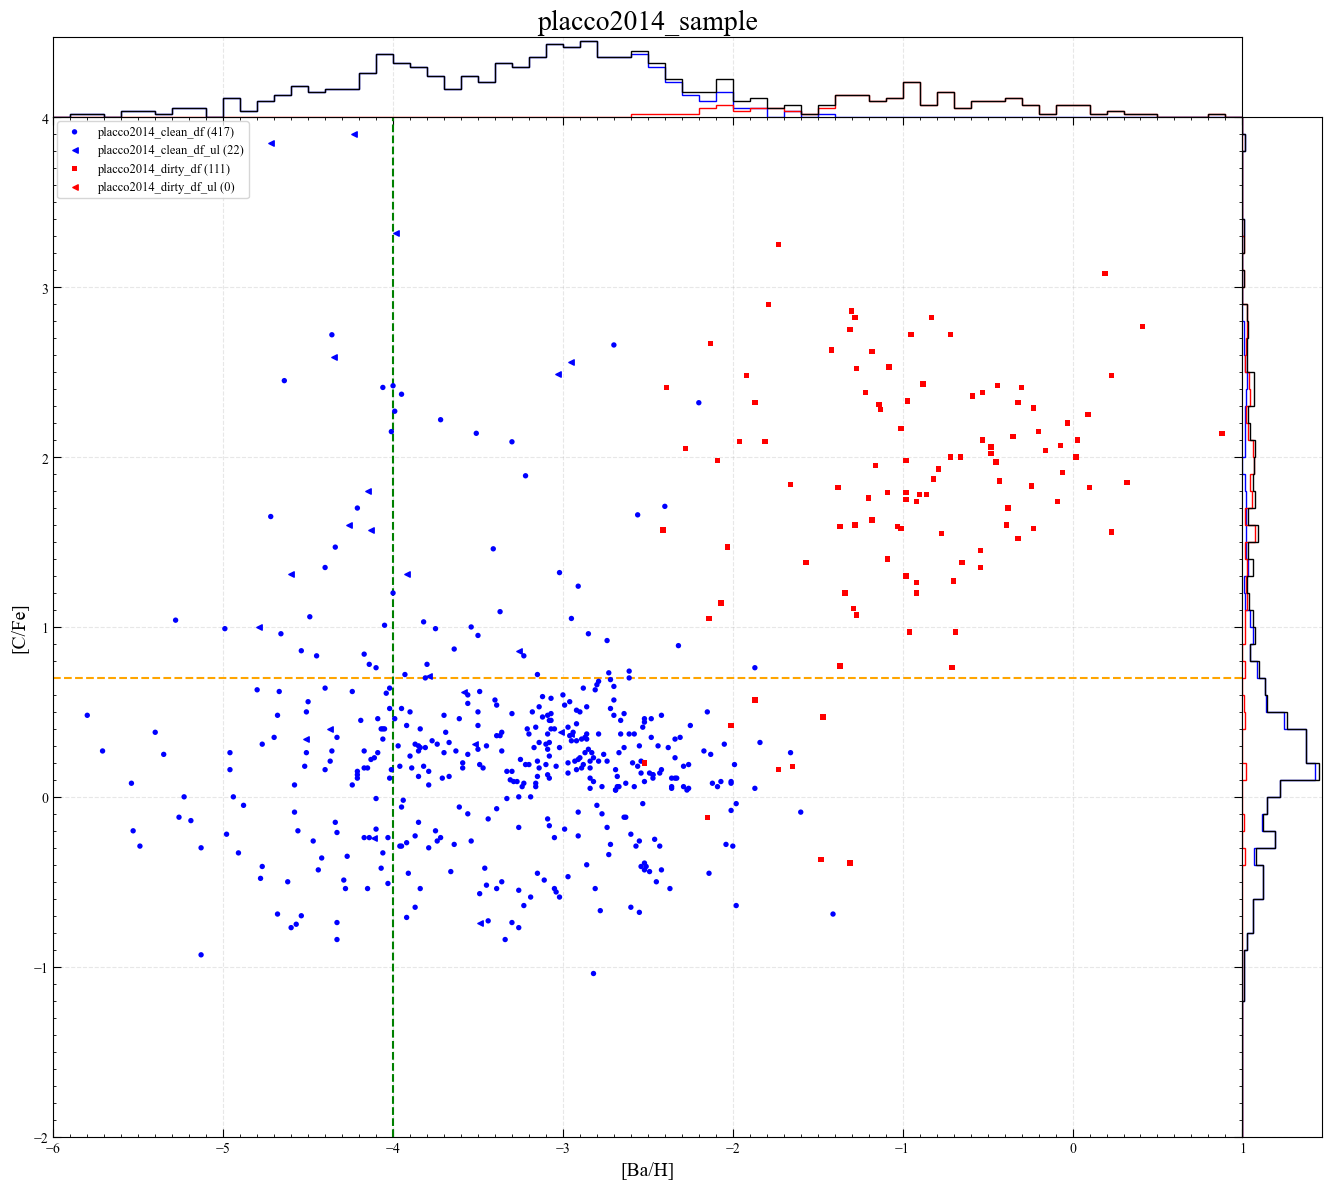

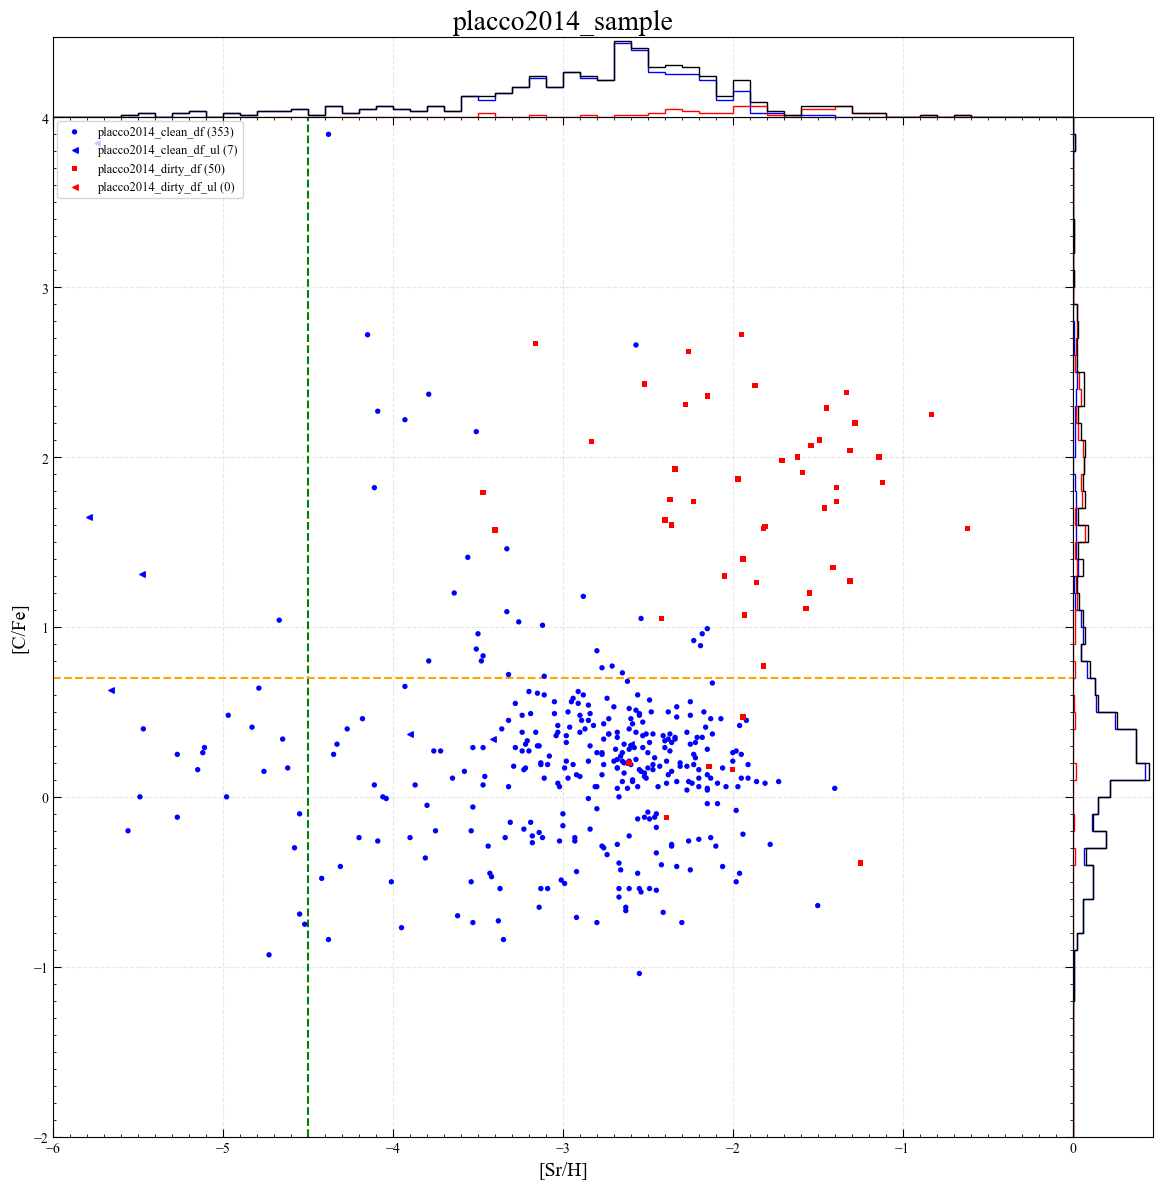

In [14]:
mw_figures = []

mw_figures.append(plot_feh_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_feh_bah(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_feh_srh(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_feh_srba(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_srh_bah(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_srfe_bafe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_bafe_srba(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_bah_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))
mw_figures.append(plot_srh_cfe(placco2014_clean_df, placco2014_dirty_df, placco2014_df, title="placco2014_sample"))

# Save all figures to a single PDF
with PdfPages(plotting_dir+'placco2014_sample.pdf') as pdf:
    for fig in mw_figures:
        pdf.savefig(fig)

### Yelland+2025 Sample

In [15]:
## Cleaned Placco2014 MW data
yelland2025_clean_df = pd.read_csv(table2_dir_clean+"placco2014_clean.csv")
yelland2025_clean_df = yelland2025_clean_df[[
    'Reference', 'Ref', 'Name', 'Class', 'MP_key',
    'Teff', 'logg', '[Fe/H]', 
    'epsc', 'epsc_c', 'epsc_f',
    '[C/H]', '[C/H]f', '[C/Fe]', '[C/Fe]f',
    '[N/Fe]', 'ul[N/Fe]',
    '[Ba/H]', 'ul[Ba/H]', '[Ba/Fe]', 'ul[Ba/Fe]',
    '[Sr/H]', 'ul[Sr/H]', '[Sr/Fe]', 'ul[Sr/Fe]',
    '[Sr/Ba]','ul[Sr/Ba]', 'I/O', 'System'
]]
yelland2025_clean_df.sort_values(by=['Name'], inplace=True)
print("Yelland2025, Clean: ", len(yelland2025_clean_df))

## Dirty Placco2014 MW data (stars not in the clean table)
yelland2025_dirty_df = placco2014_df[~placco2014_df['Name'].isin(yelland2025_clean_df['Name'])]
print("Yelland2025, Dirty: ", len(yelland2025_dirty_df))

# print()
# display(list(placco2014_clean_df.columns))


Yelland2025, Clean:  504
Yelland2025, Dirty:  111


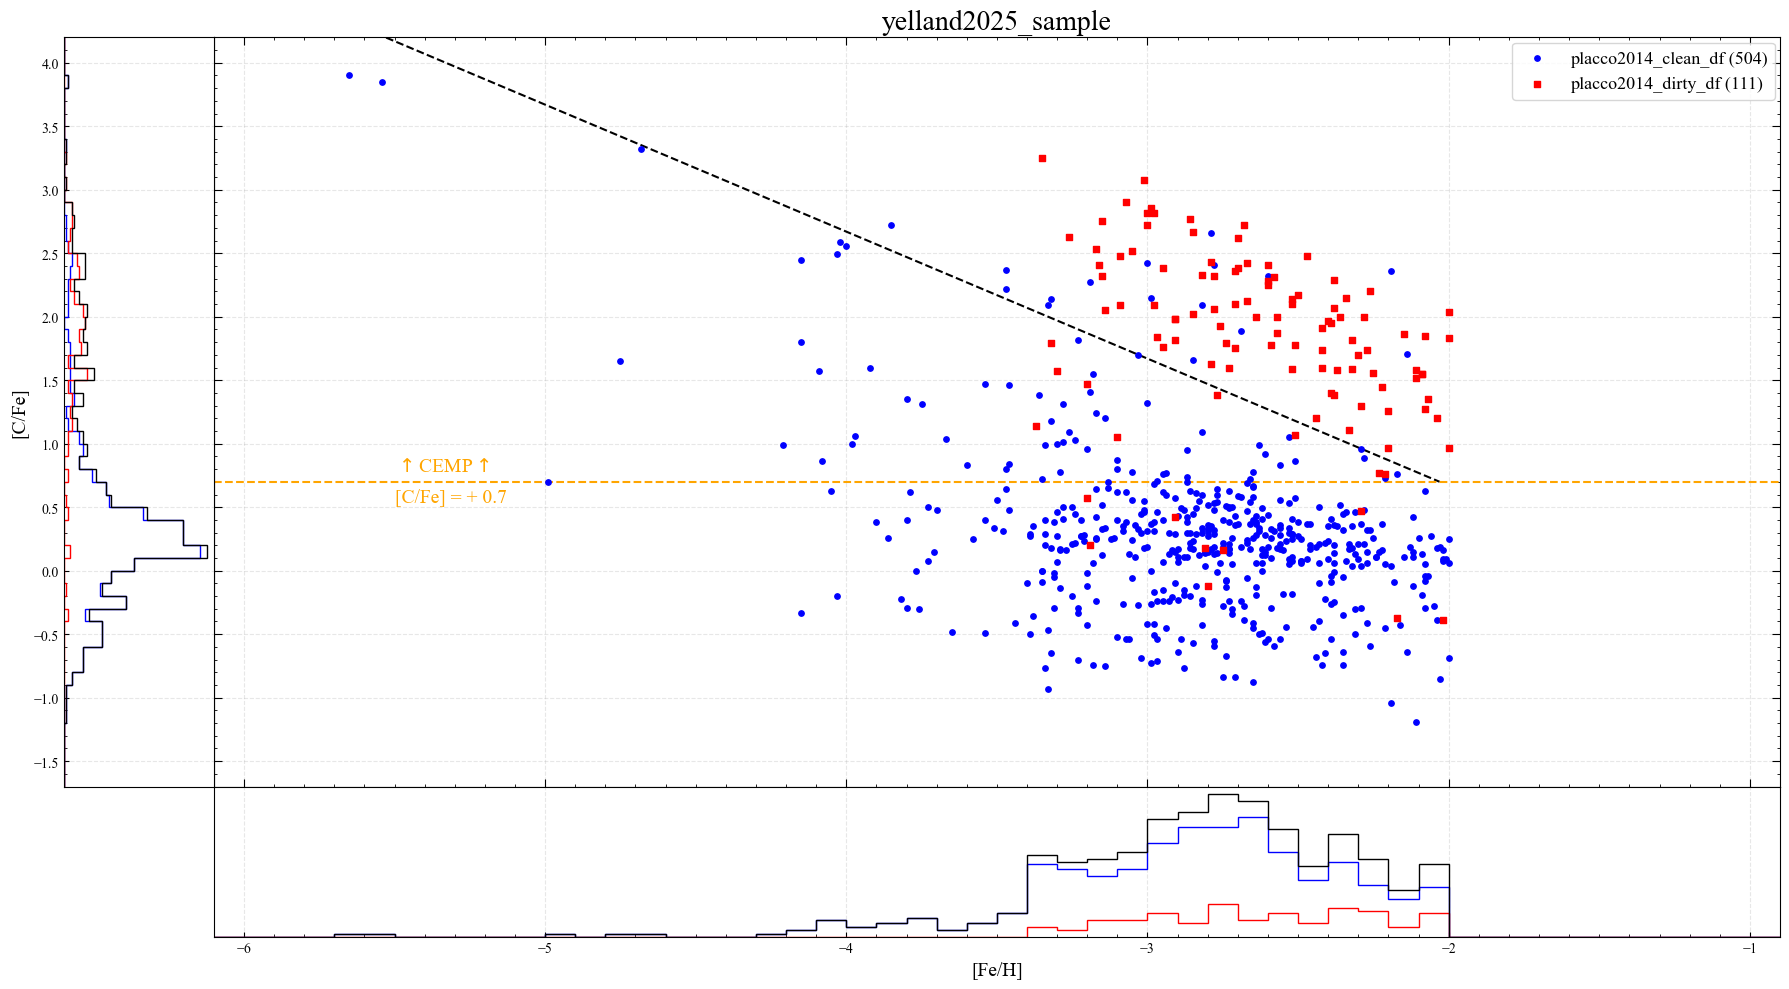

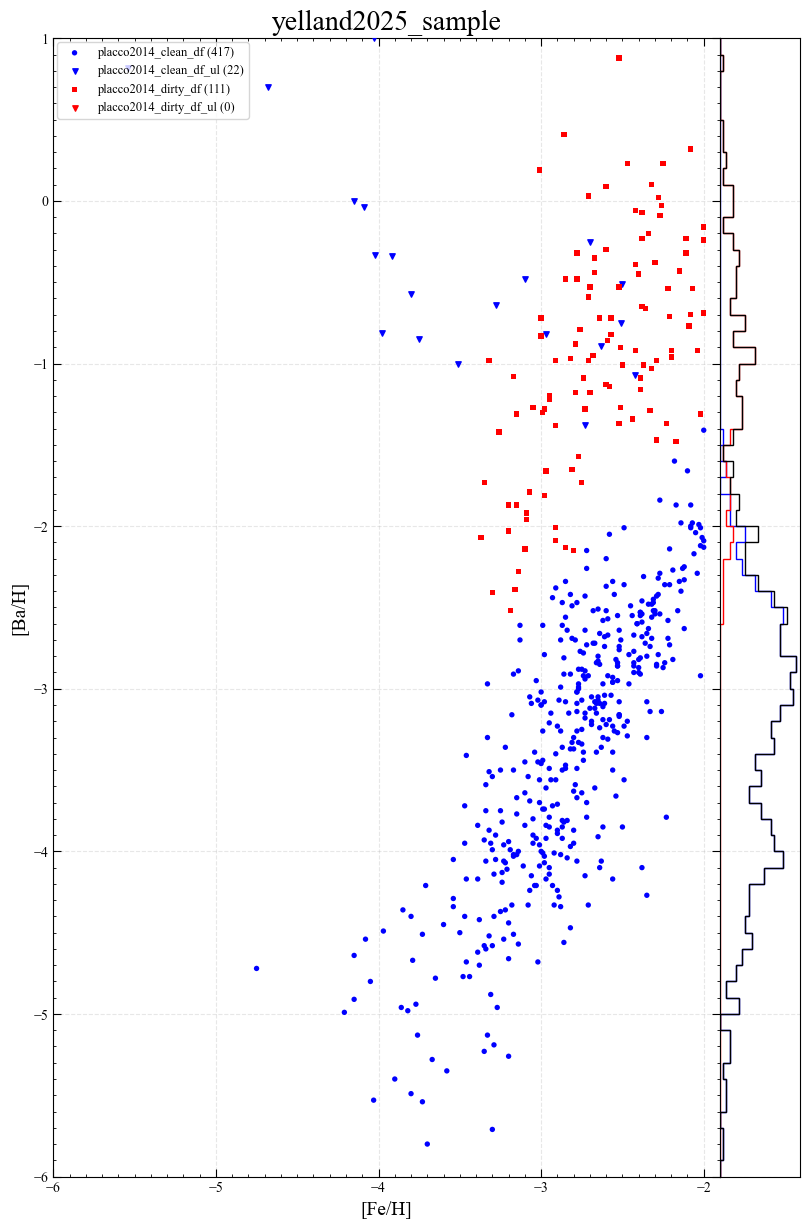

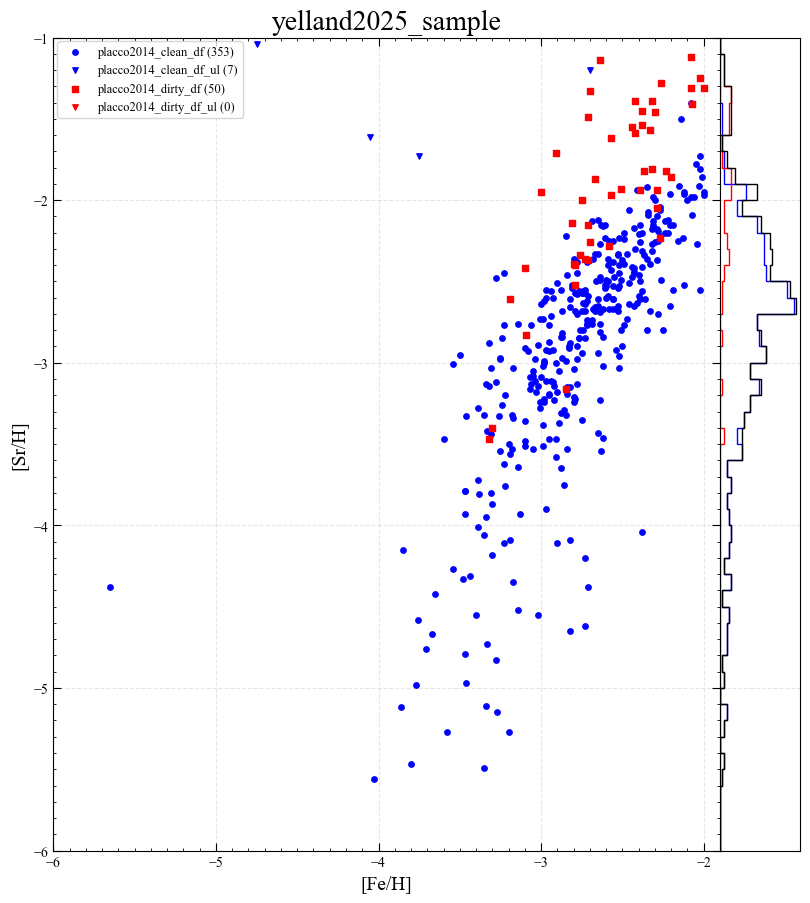

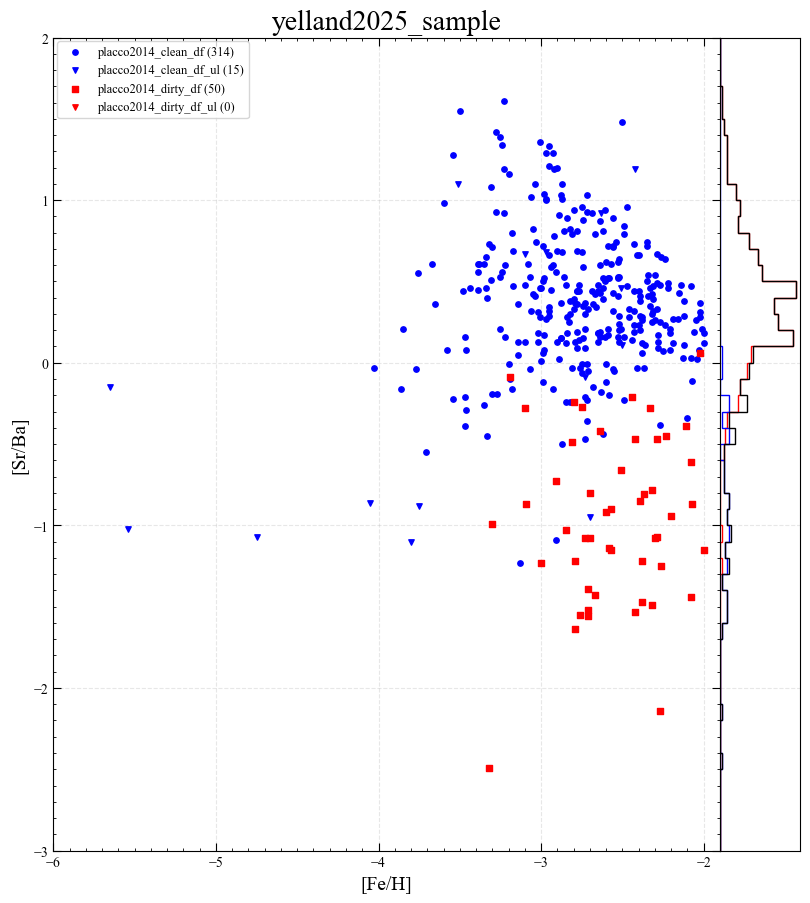

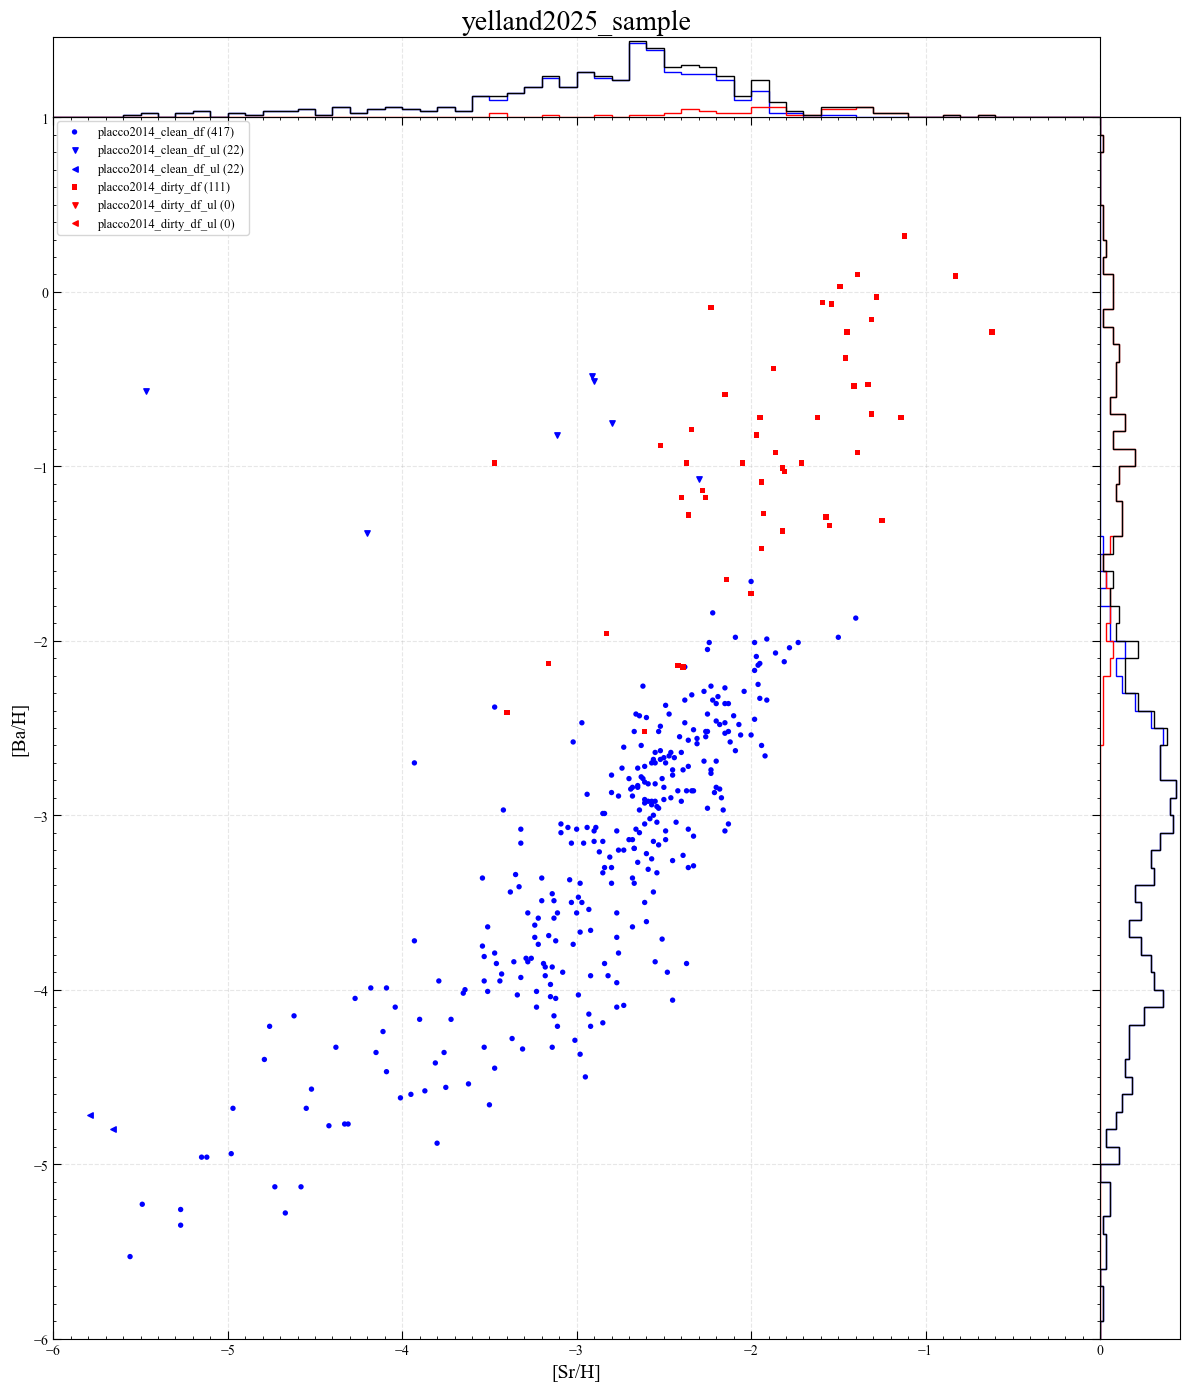

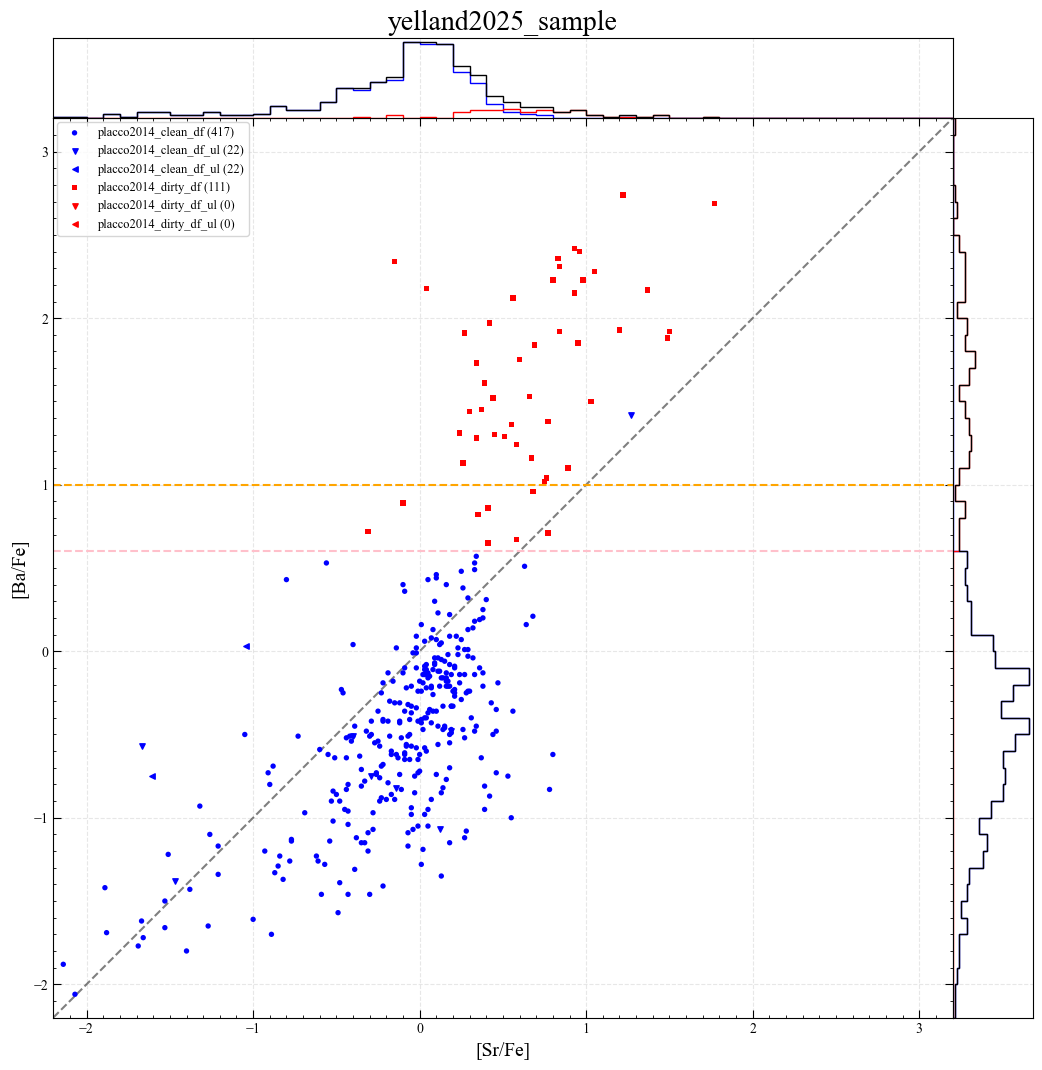

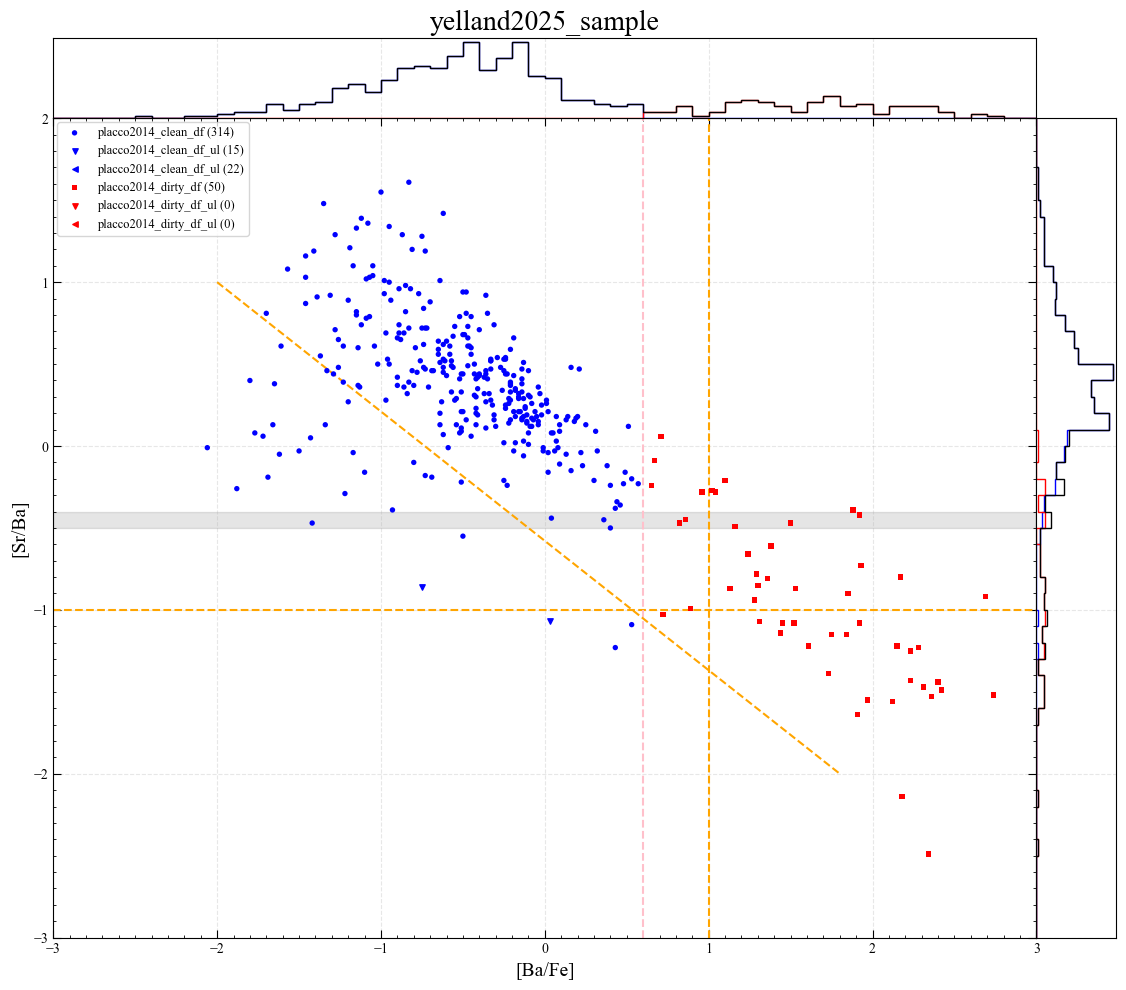

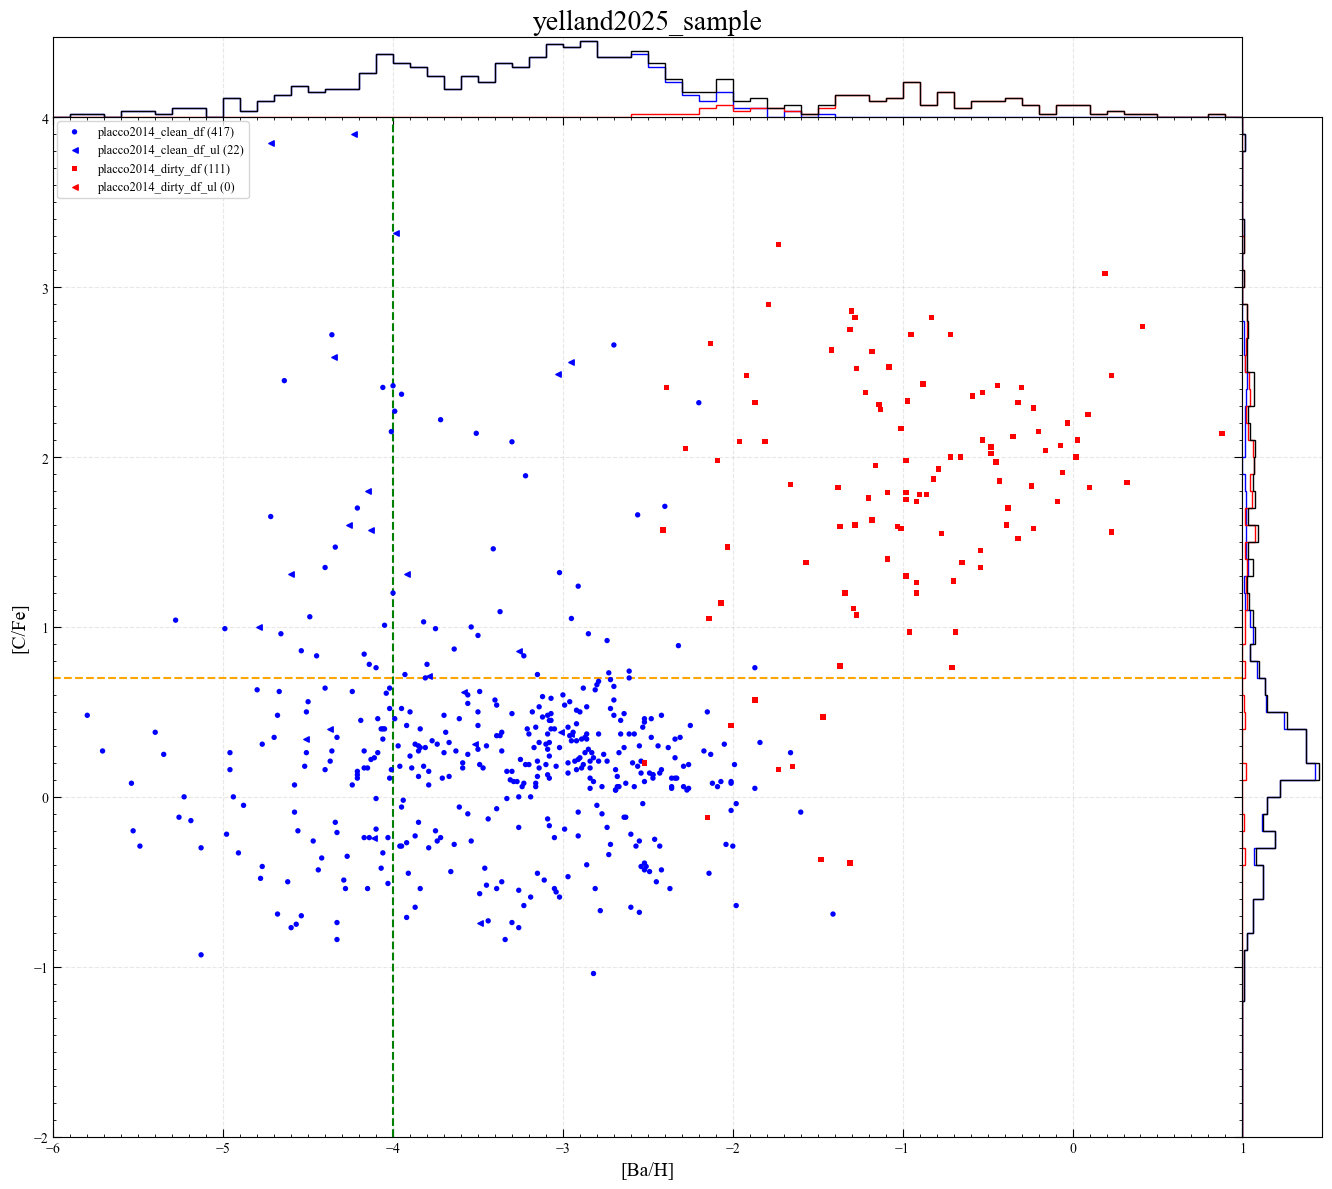

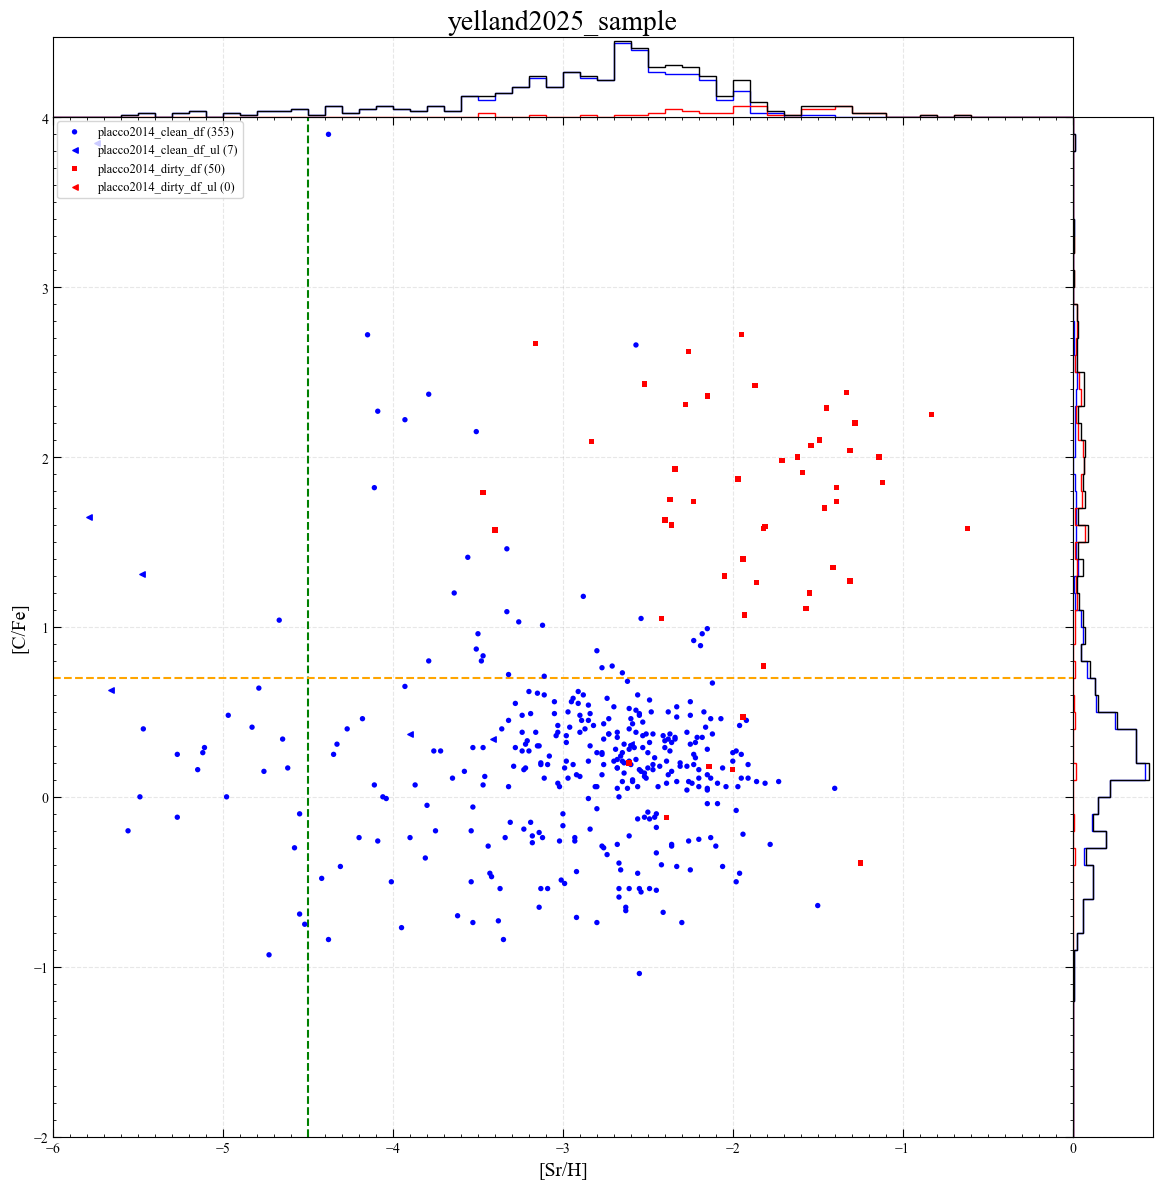

In [16]:
mw_figures = []

mw_figures.append(plot_feh_cfe(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_feh_bah(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_feh_srh(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_feh_srba(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_srh_bah(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_srfe_bafe(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_bafe_srba(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_bah_cfe(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))
mw_figures.append(plot_srh_cfe(yelland2025_clean_df, yelland2025_dirty_df, placco2014_df, title="yelland2025_sample"))

# Save all figures to a single PDF
with PdfPages(plotting_dir+'yelland2025_sample.pdf') as pdf:
    for fig in mw_figures:
        pdf.savefig(fig)

### Comparative

In [17]:
should_not_be_in_yelland2025_clean_df = placco2014_clean_df[~placco2014_clean_df['Name'].isin(yelland2025_clean_df['Name'])]
print("Clean, Not in yelland2025_clean_df: ", len(should_not_be_in_yelland2025_clean_df))

should_not_be_in_yelland2025_dirty_df = placco2014_dirty_df[~placco2014_dirty_df['Name'].isin(yelland2025_dirty_df['Name'])]
print("Dirty, Not in yelland2025_dirty_df: ", len(should_not_be_in_yelland2025_dirty_df))

display(should_not_be_in_yelland2025_dirty_df)

Clean, Not in yelland2025_clean_df:  0
Dirty, Not in yelland2025_dirty_df:  0


,Reference,Ref,Name,MP_key,Ncap_key,C_key,Teff,logg,[Fe/H],epsc,epsc_c,epsc_f,[C/H],[C/H]f,[C/Fe],[C/Fe]f,[N/Fe],ul[N/Fe],[Ba/H],ul[Ba/H],[Ba/Fe],ul[Ba/Fe],[Sr/H],ul[Sr/H],[Sr/Fe],ul[Sr/Fe],[Sr/Ba],ul[Sr/Ba],I/O


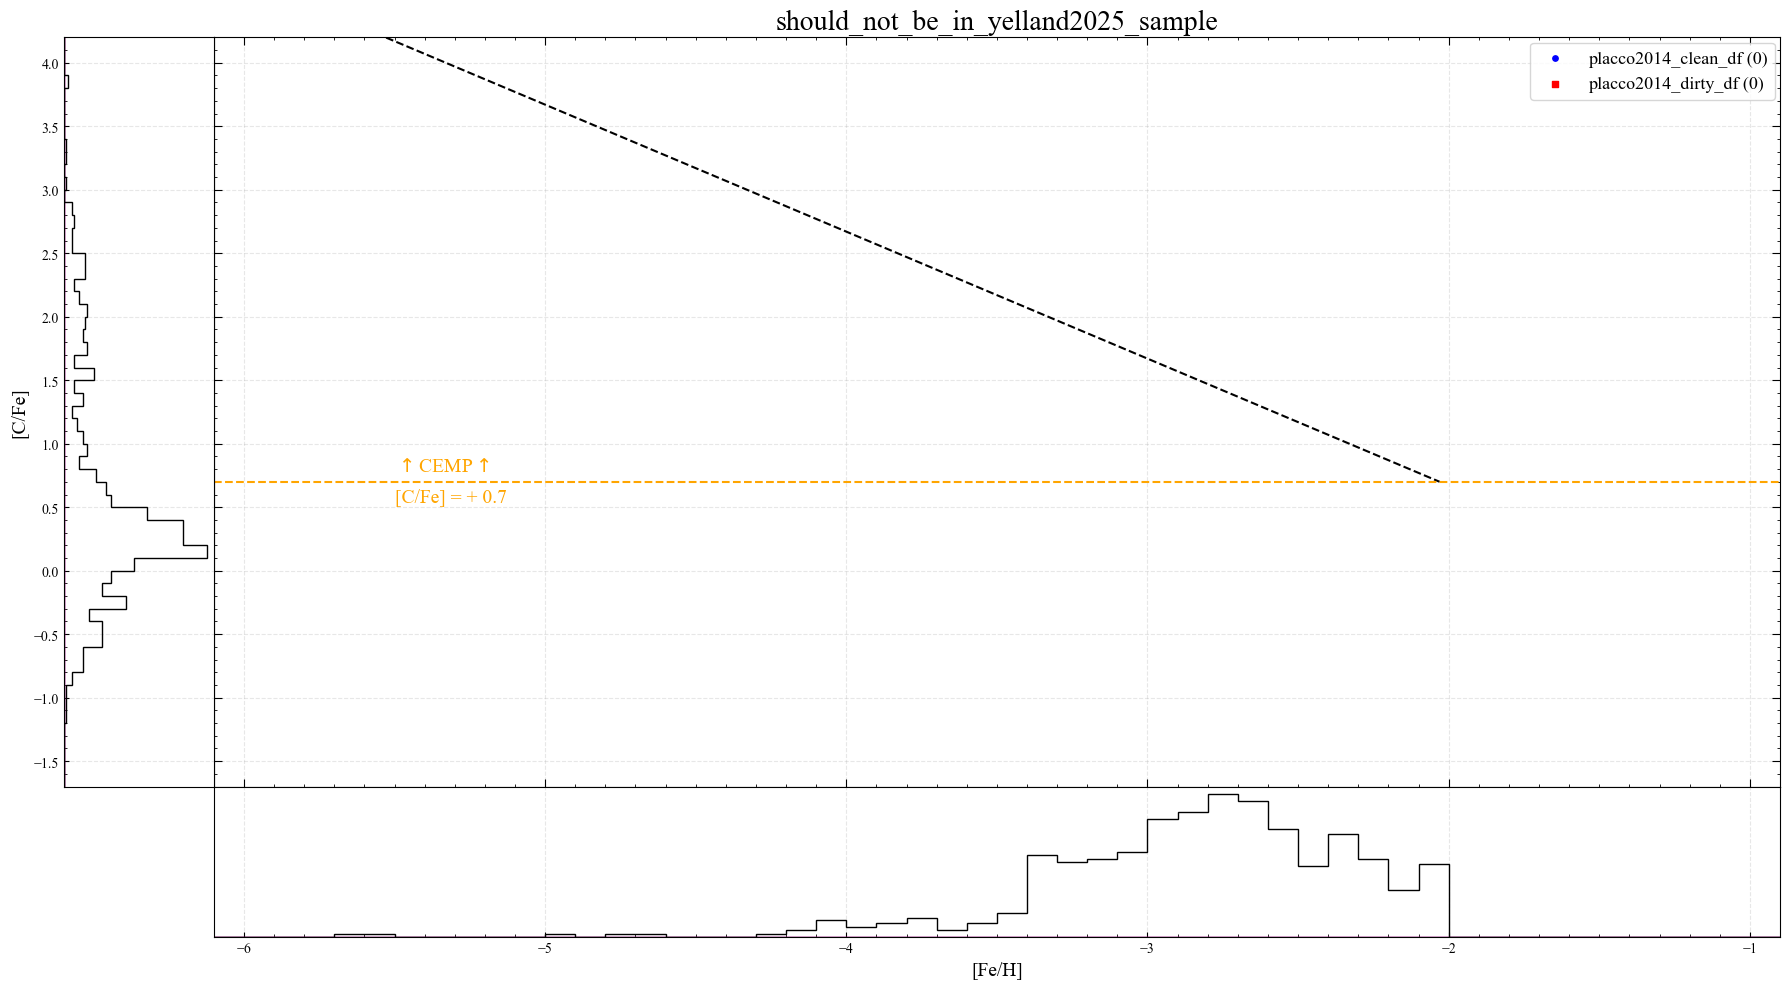

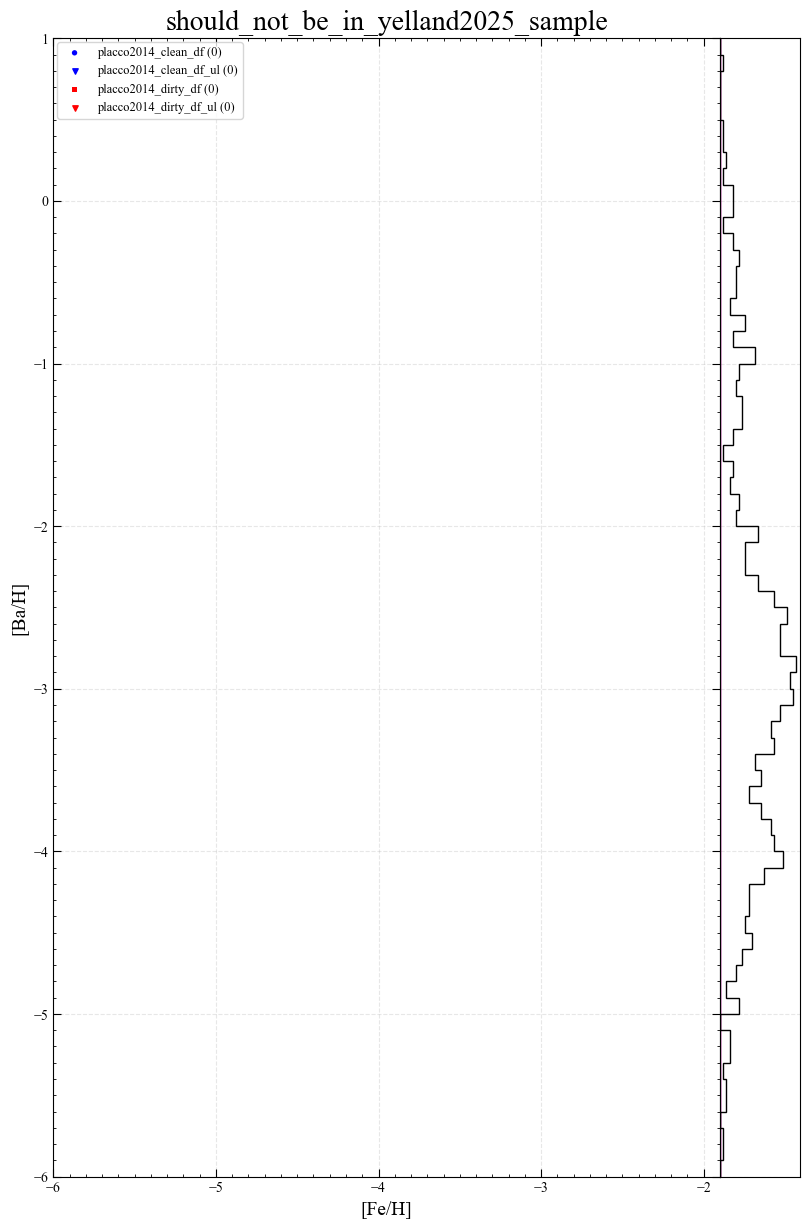

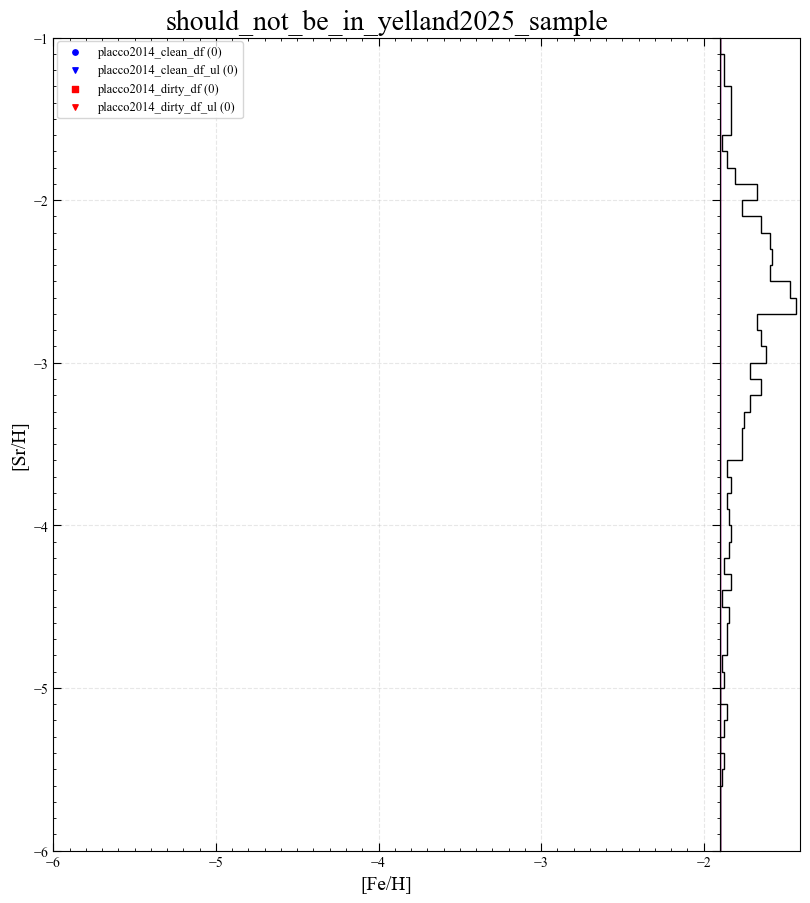

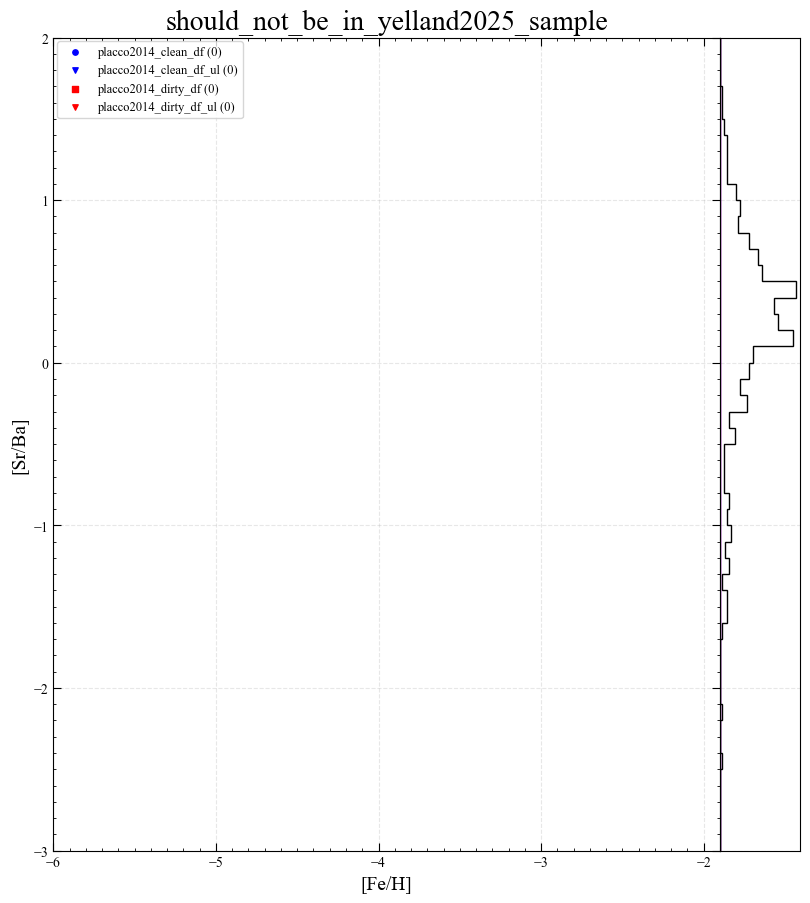

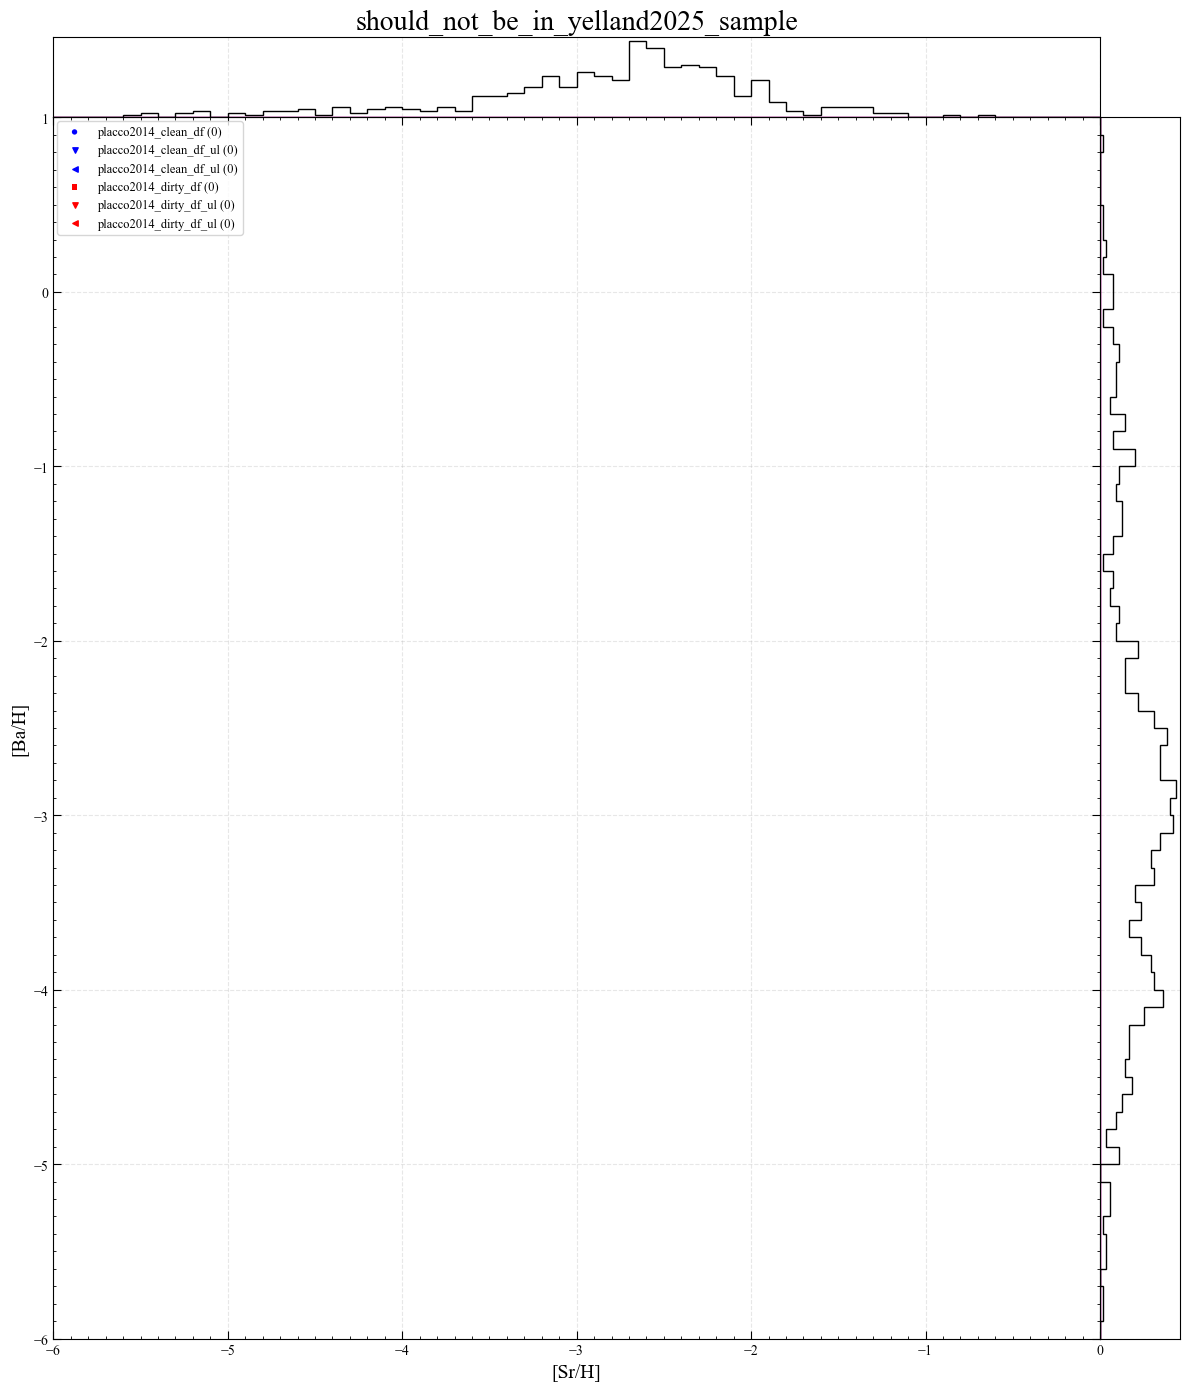

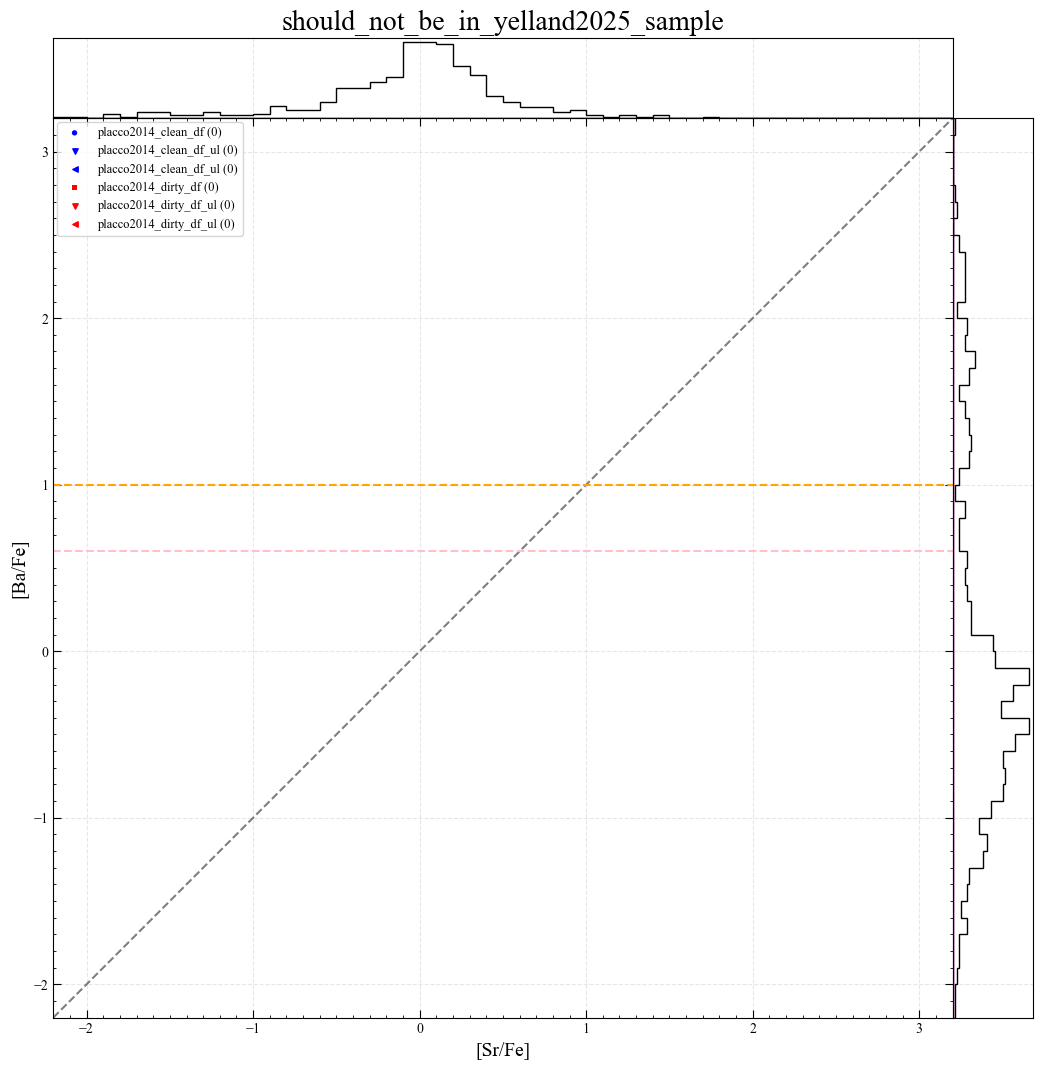

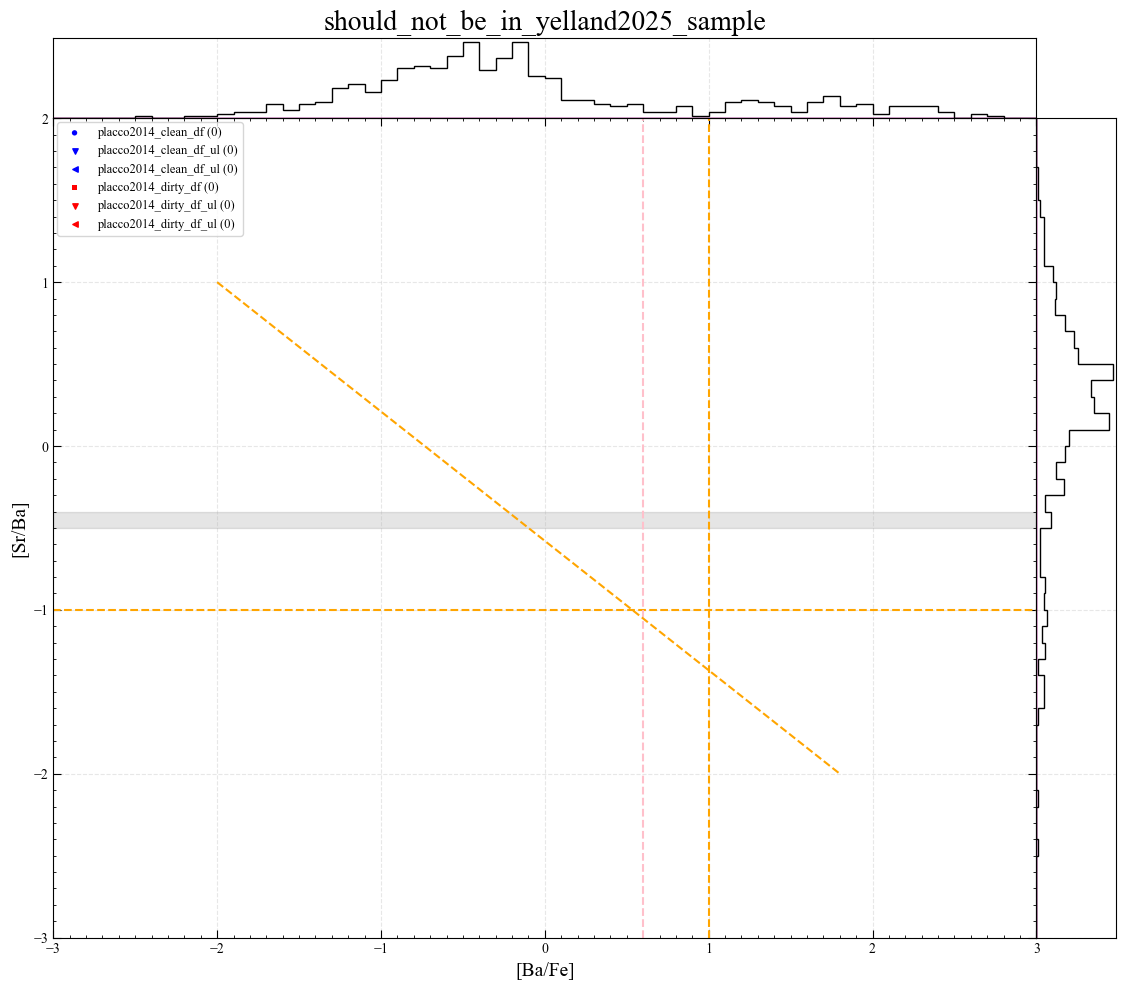

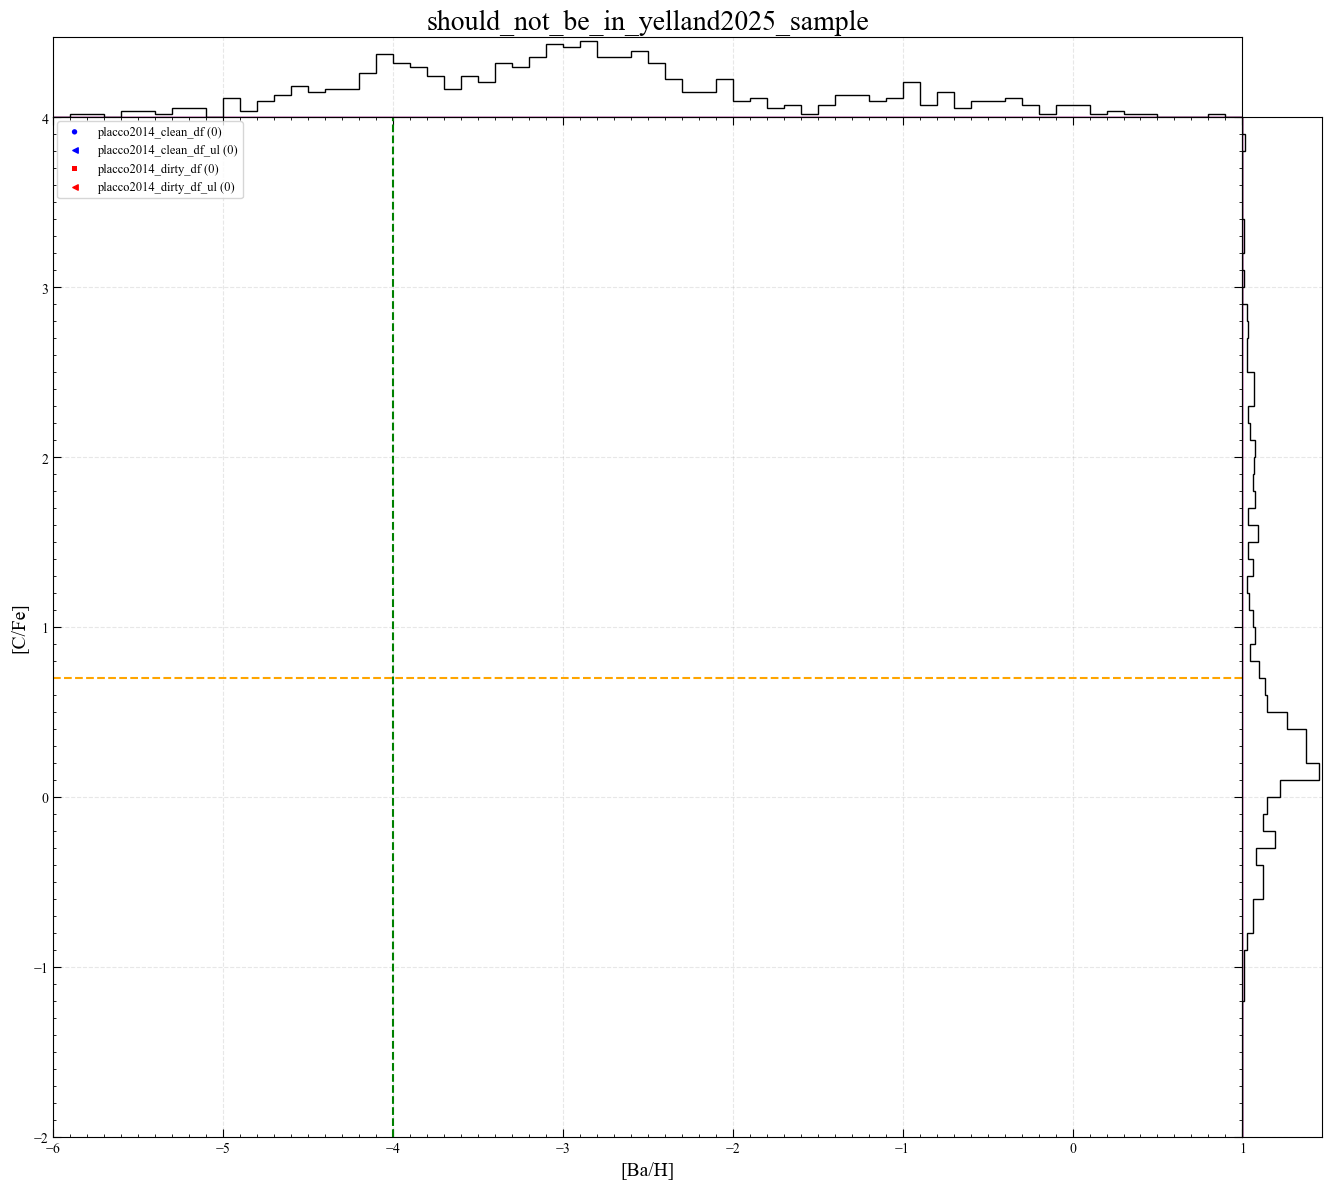

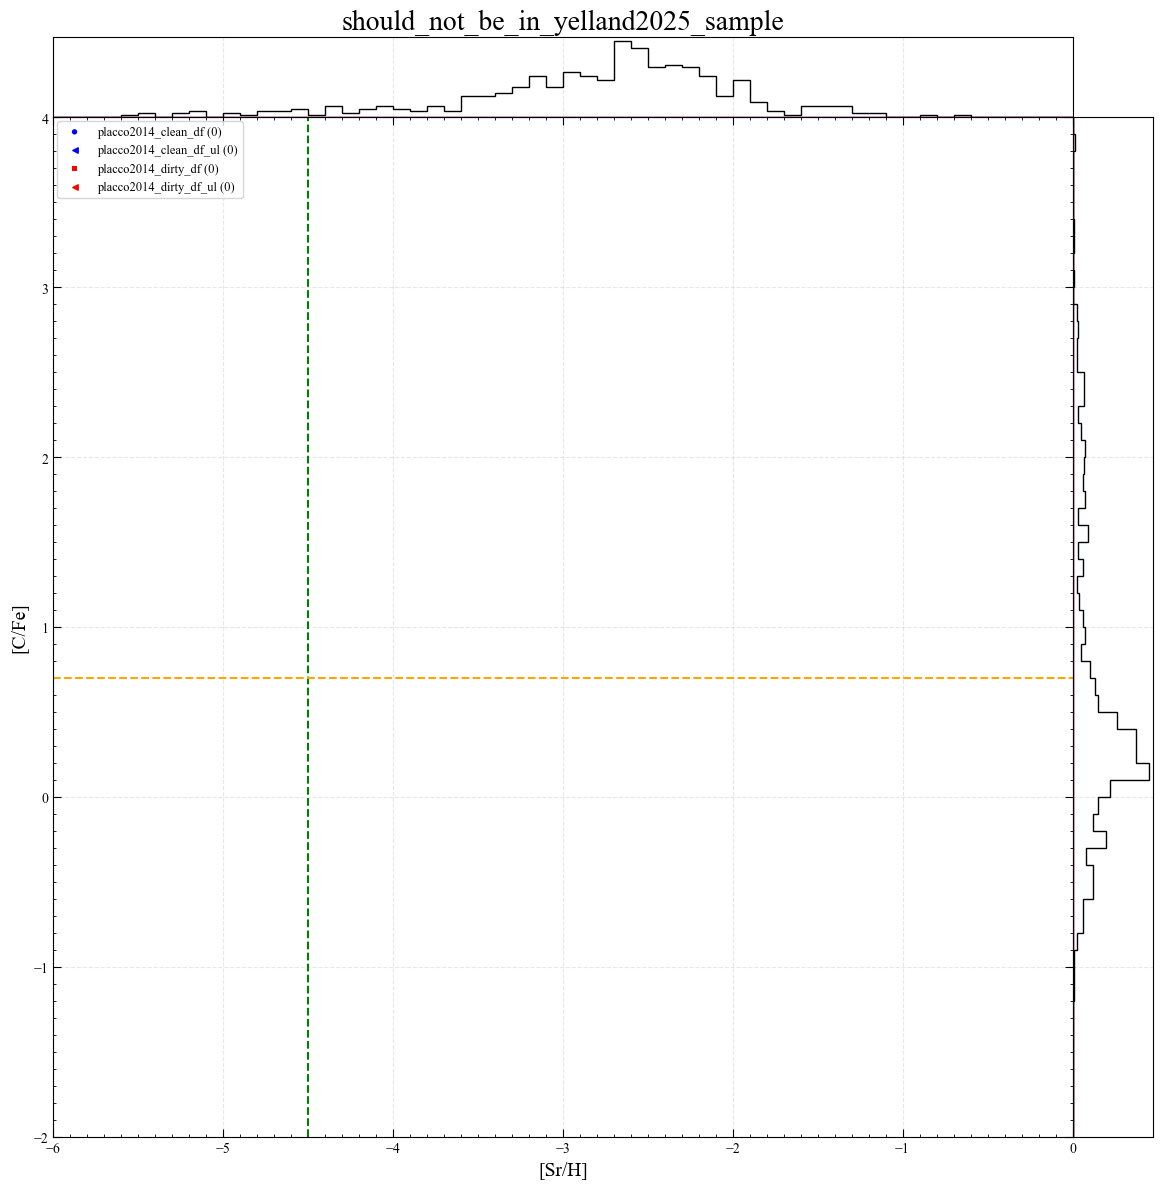

In [18]:
mw_figures = []

mw_figures.append(plot_feh_cfe(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_feh_bah(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_feh_srh(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_feh_srba(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_srh_bah(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_srfe_bafe(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_bafe_srba(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_bah_cfe(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))
mw_figures.append(plot_srh_cfe(should_not_be_in_yelland2025_clean_df, should_not_be_in_yelland2025_dirty_df, placco2014_df, title="should_not_be_in_yelland2025_sample"))

# Save all figures to a single PDF
with PdfPages(plotting_dir+'should_not_be_in_yelland2025_sample.pdf') as pdf:
    for fig in mw_figures:
        pdf.savefig(fig)